# Trabajo Práctico: Predicción de precios de casas

## Carga de librerias

In [111]:
!pip install tpot

     ---------------------------------------- 0.0/1.1 MB ? eta -:--:--
     ---------------------------------------- 0.0/1.1 MB ? eta -:--:--
     ----------------------------- ---------- 0.8/1.1 MB 4.8 MB/s eta 0:00:01
     ---------------------------------------- 1.1/1.1 MB 3.0 MB/s eta 0:00:00
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
   ---------------------------------------- 0.0/124.9 MB ? eta -:--:--
   ---------------------------------------- 0.5/124.9 MB 16.4 MB/s eta 0:00:08
   ---------------------------------------- 0.5/124.9 MB 16.4 MB/s eta 0:00:08
    --------------------------------------- 1.6/124.9 MB 3.0 MB/s eta 0:00:42
   - -------------------------------------- 3.1/124.9 MB 3.4 MB/s eta 0:00:36
   - -------------------------------------- 4.5/124.9 MB 4.0 MB/s eta 0:00:31
   - ------------------------------


[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from math import sqrt
import time
from sklearn.metrics import confusion_matrix
import joblib

from sklearn.preprocessing import (
    StandardScaler, OneHotEncoder, LabelEncoder, label_binarize
)
from sklearn.linear_model import (
    Ridge, RidgeCV, LinearRegression, SGDRegressor,
    ElasticNet, Lasso, LogisticRegression, ElasticNetCV, LassoCV)

from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor

from sklearn.metrics import (
    mean_squared_error, r2_score, mean_absolute_error,
    accuracy_score, precision_score, recall_score, f1_score,
    confusion_matrix, classification_report, roc_curve, roc_auc_score,
    auc, balanced_accuracy_score, log_loss
)

from sklearn.model_selection import (
    cross_val_score, StratifiedKFold, KFold, LeaveOneOut,
    GridSearchCV, RandomizedSearchCV, train_test_split
)



## Carga del dataset

In [2]:
# Cargar el dataset
df = pd.read_csv(r'weatherAUS.csv')

### Elegimos las ciudades

In [3]:
# Obtener los valores únicos de la columna 'Location'
unique_locations = df['Location'].unique()

In [4]:
# Seleccionar aleatoriamente 10 ciudades
selected_cities = np.random.choice(unique_locations, size=10, replace=False)


In [5]:
# Filtrar el DataFrame para quedarse solo con las ciudades seleccionadas
df = df[df['Location'].isin(selected_cities)]

# Mostrar las primeras filas del DataFrame filtrado
df.head()


,Date,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,...,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,RainTomorrow
9058,2009-01-01,CoffsHarbour,16.1,31.4,0.0,7.4,11.4,NNE,54.0,N,...,51.0,58.0,1005.9,1002.3,1.0,5.0,26.5,28.4,No,No
9059,2009-01-02,CoffsHarbour,22.8,24.7,0.0,8.0,0.2,SSW,56.0,SSW,...,68.0,67.0,1010.9,1011.4,7.0,7.0,23.4,24.4,No,Yes
9060,2009-01-03,CoffsHarbour,20.0,24.1,4.6,3.4,0.2,SE,35.0,SE,...,70.0,59.0,1019.3,1018.8,8.0,7.0,21.7,23.7,Yes,No
9061,2009-01-04,CoffsHarbour,14.8,25.0,0.8,3.0,12.6,E,24.0,SSE,...,62.0,45.0,1019.5,1017.0,5.0,2.0,22.5,24.8,No,No
9062,2009-01-05,CoffsHarbour,15.5,27.3,0.0,6.6,13.1,NE,41.0,NW,...,54.0,62.0,1015.7,1012.7,1.0,6.0,24.6,26.1,No,No


In [6]:
#Eliminaremos esta columna, ya que vamos a tomar las ubicaciones como si fueran una misma y así simplificar el modelo.
df.drop('Location', axis=1, inplace=True)

In [7]:
nulos_raintomorrow = df["RainTomorrow"].isnull().sum()

print("El Dataset cuenta con " +  str(nulos_raintomorrow) + " Valores nulos en la variable a predecir.")


El Dataset cuenta con 971 Valores nulos en la variable a predecir.


In [8]:
#Eliminamos del Dataset las filas que en la columna RainTomorrow sean nulas, ya que no nos sirve para el modelo.
df = df.dropna(subset=["RainTomorrow"])

# División del conjunto de datos, Train y Test

Dividimos el dataset en train y test antes de imputar nulos para evitar el data leakage. Al hacerlo por fecha, mantenemos la integridad temporal y respetamos el orden cronológico de los eventos. Esto es crucial para series temporales y problemas donde el tiempo importa. Si usáramos una división aleatoria como `train_test_split`, podríamos filtrar datos de prueba en el entrenamiento, lo que llevaría a un modelo sobreajustado que no generaliza bien en datos futuros.

In [9]:
# Convierto la columna 'Date' a tipo datetime
df["Date"] = pd.to_datetime(df["Date"])

# Mostrar la primera y última fecha
primera_fecha = df['Date'].min()
ultima_fecha = df['Date'].max()

print("Primera fecha:", primera_fecha)
print("Última fecha:", ultima_fecha)

# Calcular la fecha que abarque el 80% de los datos
fecha_80porciento = df['Date'].quantile(0.8)

print("Fecha que abarca el 80% de los datos:", fecha_80porciento)


Primera fecha: 2008-07-01 00:00:00
Última fecha: 2017-06-25 00:00:00
Fecha que abarca el 80% de los datos: 2015-11-02 00:00:00


In [10]:
# Dividir los datos en conjuntos de entrenamiento y prueba basados en la fecha
train = df[df['Date'] <= fecha_80porciento]

test = df[df['Date'] > fecha_80porciento]


print("Tamaño del conjunto de entrenamiento:", train.shape)
print("Tamaño del conjunto de prueba:", test.shape)

Tamaño del conjunto de entrenamiento: (23520, 22)
Tamaño del conjunto de prueba: (5873, 22)


Ya que la fecha no aporta nada más de valor, procedemos a eliminarla para reducir un poco más la dimensionalidad y así la complejidad de nuestro modelo.

In [11]:
train = train.drop('Date', axis=1)

test = test.drop('Date', axis=1)

In [12]:
train

,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,WindDir3pm,WindSpeed9am,...,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,RainTomorrow
9058,16.1,31.4,0.0,7.4,11.4,NNE,54.0,N,NNE,7.0,...,51.0,58.0,1005.9,1002.3,1.0,5.0,26.5,28.4,No,No
9059,22.8,24.7,0.0,8.0,0.2,SSW,56.0,SSW,S,35.0,...,68.0,67.0,1010.9,1011.4,7.0,7.0,23.4,24.4,No,Yes
9060,20.0,24.1,4.6,3.4,0.2,SE,35.0,SE,E,20.0,...,70.0,59.0,1019.3,1018.8,8.0,7.0,21.7,23.7,Yes,No
9061,14.8,25.0,0.8,3.0,12.6,E,24.0,SSE,ESE,7.0,...,62.0,45.0,1019.5,1017.0,5.0,2.0,22.5,24.8,No,No
9062,15.5,27.3,0.0,6.6,13.1,NE,41.0,NW,NE,7.0,...,54.0,62.0,1015.7,1012.7,1.0,6.0,24.6,26.1,No,No
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
138505,24.6,30.5,0.0,13.0,0.0,E,31.0,NE,NE,11.0,...,25.0,24.0,1016.8,1014.9,8.0,4.0,29.0,29.1,No,No
138506,19.8,35.1,0.0,6.4,5.7,NNW,50.0,E,NW,20.0,...,21.0,18.0,1015.2,1012.3,7.0,7.0,28.6,32.0,No,No
138507,19.1,38.0,0.0,9.0,10.3,NNW,39.0,WNW,NNE,11.0,...,23.0,15.0,1013.3,1008.1,5.0,6.0,30.9,37.1,No,No
138508,18.4,40.0,0.0,11.6,10.4,ESE,48.0,NW,ESE,4.0,...,20.0,10.0,1011.5,1006.0,1.0,6.0,31.6,37.9,No,No


In [13]:
test

,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,WindDir3pm,WindSpeed9am,...,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,RainTomorrow
11466,19.3,25.6,0.8,NaN,NaN,NNW,33.0,SE,SSE,7.0,...,73.0,74.0,1014.0,1012.5,8.0,8.0,25.0,22.9,No,Yes
11467,17.1,24.1,13.0,NaN,NaN,S,24.0,S,WSW,13.0,...,81.0,95.0,1016.2,1014.3,6.0,8.0,22.1,21.0,Yes,Yes
11468,19.6,23.7,19.6,NaN,NaN,NE,50.0,ENE,ENE,19.0,...,96.0,94.0,1016.1,1014.0,8.0,8.0,20.4,21.5,Yes,Yes
11469,20.1,28.3,7.2,NaN,NaN,NE,46.0,NNE,NE,17.0,...,81.0,66.0,1010.9,1006.4,NaN,NaN,23.3,25.6,Yes,No
11471,18.2,20.7,NaN,NaN,NaN,SSW,39.0,SSW,SW,7.0,...,92.0,96.0,1016.5,1017.4,8.0,7.0,19.4,17.9,NaN,Yes
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
139105,0.7,21.3,0.0,NaN,NaN,E,31.0,WNW,ESE,6.0,...,54.0,25.0,1024.6,1020.9,NaN,NaN,9.2,20.7,No,No
139106,1.6,23.1,0.0,NaN,NaN,ESE,30.0,NaN,SE,0.0,...,50.0,26.0,1024.9,1020.5,NaN,NaN,11.3,22.8,No,No
139107,2.9,25.6,0.0,NaN,NaN,E,26.0,NaN,SE,0.0,...,53.0,23.0,1023.9,1019.4,NaN,NaN,11.6,25.1,No,No
139108,4.1,27.8,0.0,NaN,NaN,N,19.0,NE,N,7.0,...,45.0,18.0,1021.4,1017.3,NaN,NaN,15.1,27.2,No,No


# Visualización de datos Train

Examinaremos los datos para un primer vistazo.

In [14]:
train.head()

,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,WindDir3pm,WindSpeed9am,...,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,RainTomorrow
9058,16.1,31.4,0.0,7.4,11.4,NNE,54.0,N,NNE,7.0,...,51.0,58.0,1005.9,1002.3,1.0,5.0,26.5,28.4,No,No
9059,22.8,24.7,0.0,8.0,0.2,SSW,56.0,SSW,S,35.0,...,68.0,67.0,1010.9,1011.4,7.0,7.0,23.4,24.4,No,Yes
9060,20.0,24.1,4.6,3.4,0.2,SE,35.0,SE,E,20.0,...,70.0,59.0,1019.3,1018.8,8.0,7.0,21.7,23.7,Yes,No
9061,14.8,25.0,0.8,3.0,12.6,E,24.0,SSE,ESE,7.0,...,62.0,45.0,1019.5,1017.0,5.0,2.0,22.5,24.8,No,No
9062,15.5,27.3,0.0,6.6,13.1,NE,41.0,NW,NE,7.0,...,54.0,62.0,1015.7,1012.7,1.0,6.0,24.6,26.1,No,No


In [15]:
train.columns

Index(['MinTemp', 'MaxTemp', 'Rainfall', 'Evaporation', 'Sunshine',
       'WindGustDir', 'WindGustSpeed', 'WindDir9am', 'WindDir3pm',
       'WindSpeed9am', 'WindSpeed3pm', 'Humidity9am', 'Humidity3pm',
       'Pressure9am', 'Pressure3pm', 'Cloud9am', 'Cloud3pm', 'Temp9am',
       'Temp3pm', 'RainToday', 'RainTomorrow'],
      dtype='object')

A continuación, examinaremos qué tipos de variables son estas columnas.

In [16]:
train.dtypes

MinTemp          float64
MaxTemp          float64
Rainfall         float64
Evaporation      float64
Sunshine         float64
WindGustDir       object
WindGustSpeed    float64
WindDir9am        object
WindDir3pm        object
WindSpeed9am     float64
WindSpeed3pm     float64
Humidity9am      float64
Humidity3pm      float64
Pressure9am      float64
Pressure3pm      float64
Cloud9am         float64
Cloud3pm         float64
Temp9am          float64
Temp3pm          float64
RainToday         object
RainTomorrow      object
dtype: object

Investiguemos la presencia de valores nulos en los datos.

In [17]:
train.isna().sum()

MinTemp            86
MaxTemp            30
Rainfall          334
Evaporation      8030
Sunshine         8619
WindGustDir       744
WindGustSpeed     710
WindDir9am       1320
WindDir3pm        530
WindSpeed9am      444
WindSpeed3pm      426
Humidity9am       726
Humidity3pm       567
Pressure9am      2734
Pressure3pm      2731
Cloud9am         9084
Cloud3pm         9290
Temp9am           424
Temp3pm           264
RainToday         334
RainTomorrow        0
dtype: int64

Los valores faltantes de cada columna los trataremos.

Para concluir nuestra primera inspección, veremos las estadísticas descriptivas del conjunto de datos.

In [18]:
train.describe(include='all')

,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,WindDir3pm,WindSpeed9am,...,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,RainTomorrow
count,23434.00000,23490.000000,23186.000000,15490.000000,14901.000000,22776,22810.000000,22200,22990,23076.000000,...,22794.000000,22953.000000,20786.000000,20789.000000,14436.000000,14230.000000,23096.000000,23256.000000,23186,23520
unique,NaN,NaN,NaN,NaN,NaN,16,NaN,16,16,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2,2
top,NaN,NaN,NaN,NaN,NaN,SE,NaN,NNW,SE,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,No,No
freq,NaN,NaN,NaN,NaN,NaN,1787,NaN,2179,2394,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,16798,17003
mean,10.88707,20.658612,2.743707,4.739141,7.191974,NaN,42.362166,NaN,NaN,16.107428,...,68.941695,57.347057,1017.550625,1015.560518,4.600305,4.637526,15.750905,19.173865,NaN,NaN
std,5.77963,6.998124,8.954942,3.793528,3.775942,NaN,14.007494,NaN,NaN,8.292070,...,20.186397,20.909906,7.453444,7.366186,2.817651,2.675906,6.220593,6.844022,NaN,NaN
min,-8.50000,-4.100000,0.000000,0.000000,0.000000,NaN,9.000000,NaN,NaN,0.000000,...,1.000000,1.000000,980.500000,979.000000,0.000000,0.000000,-6.200000,-5.100000,NaN,NaN
25%,7.00000,16.400000,0.000000,2.200000,4.300000,NaN,33.000000,NaN,NaN,11.000000,...,57.000000,46.000000,1012.900000,1011.000000,2.000000,2.000000,11.700000,15.000000,NaN,NaN
50%,10.90000,20.100000,0.000000,4.000000,7.800000,NaN,39.000000,NaN,NaN,15.000000,...,70.000000,59.000000,1018.000000,1015.900000,5.000000,5.000000,15.700000,18.800000,NaN,NaN
75%,14.90000,24.700000,1.400000,6.200000,10.300000,NaN,50.000000,NaN,NaN,20.000000,...,84.000000,71.000000,1022.600000,1020.500000,7.000000,7.000000,19.800000,23.000000,NaN,NaN


In [19]:
# Información general del dataset
train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 23520 entries, 9058 to 138509
Data columns (total 21 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   MinTemp        23434 non-null  float64
 1   MaxTemp        23490 non-null  float64
 2   Rainfall       23186 non-null  float64
 3   Evaporation    15490 non-null  float64
 4   Sunshine       14901 non-null  float64
 5   WindGustDir    22776 non-null  object 
 6   WindGustSpeed  22810 non-null  float64
 7   WindDir9am     22200 non-null  object 
 8   WindDir3pm     22990 non-null  object 
 9   WindSpeed9am   23076 non-null  float64
 10  WindSpeed3pm   23094 non-null  float64
 11  Humidity9am    22794 non-null  float64
 12  Humidity3pm    22953 non-null  float64
 13  Pressure9am    20786 non-null  float64
 14  Pressure3pm    20789 non-null  float64
 15  Cloud9am       14436 non-null  float64
 16  Cloud3pm       14230 non-null  float64
 17  Temp9am        23096 non-null  float64
 18  Temp3pm

In [20]:
# Contamos el número total de filas que tengan todos sus valores como nulos
nulas = train.isnull().all(axis=1).sum()
nulas

0

In [21]:
train.count()

MinTemp          23434
MaxTemp          23490
Rainfall         23186
Evaporation      15490
Sunshine         14901
WindGustDir      22776
WindGustSpeed    22810
WindDir9am       22200
WindDir3pm       22990
WindSpeed9am     23076
WindSpeed3pm     23094
Humidity9am      22794
Humidity3pm      22953
Pressure9am      20786
Pressure3pm      20789
Cloud9am         14436
Cloud3pm         14230
Temp9am          23096
Temp3pm          23256
RainToday        23186
RainTomorrow     23520
dtype: int64

# Graficos de Train

### MinTemp

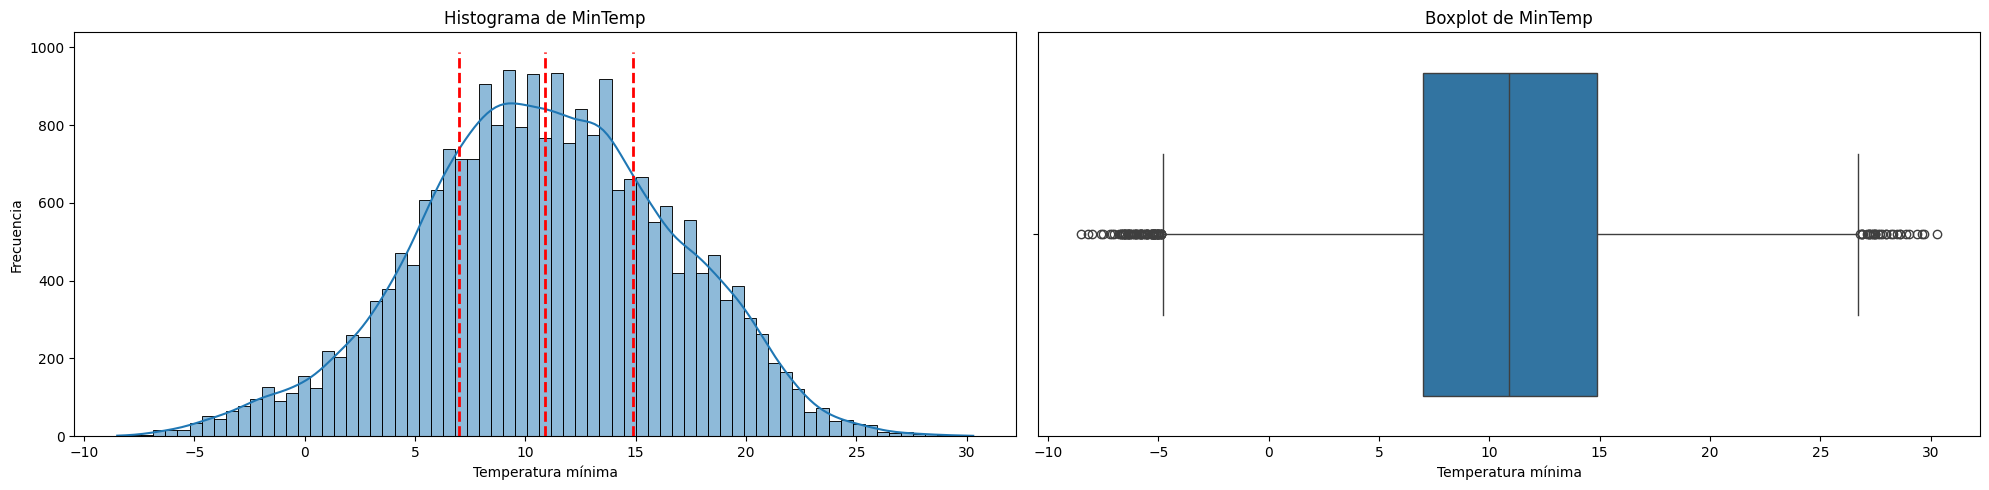

count    23434.00000
mean        10.88707
std          5.77963
min         -8.50000
25%          7.00000
50%         10.90000
75%         14.90000
max         30.30000
Name: MinTemp, dtype: float64

In [22]:
fig, axs = plt.subplots(1, 2, figsize=(20, 5))

# Histograma
sns.histplot(train['MinTemp'], kde=True, ax=axs[0])
axs[0].set_title('Histograma de MinTemp')
axs[0].set_xlabel('Temperatura mínima')
axs[0].set_ylabel('Frecuencia')

# Calcular cuartiles
q1 = train['MinTemp'].quantile(0.25)
q2 = train['MinTemp'].quantile(0.5)
q3 = train['MinTemp'].quantile(0.75)

# Agregue líneas de cuartil con ymin e ymax establecidos en todo el rango y del gráfico
axs[0].vlines([q1, q2, q3], color='red', linestyles='dashed', linewidths=2,
              ymin=axs[0].get_ylim()[0], ymax=axs[0].get_ylim()[1])

# Boxplot
sns.boxplot(x=train['MinTemp'], ax=axs[1])
axs[1].set_title('Boxplot de MinTemp')
axs[1].set_xlabel('Temperatura mínima')

plt.tight_layout()
plt.show()

train['MinTemp'].describe()

La variable MinTemp posee una distribución normal, predominando una temperatura de 10/12° aproximadamente. La misma, tiene picos de 33, y minimos de -8°, siendo estos casos extremos.

### MaxTemp

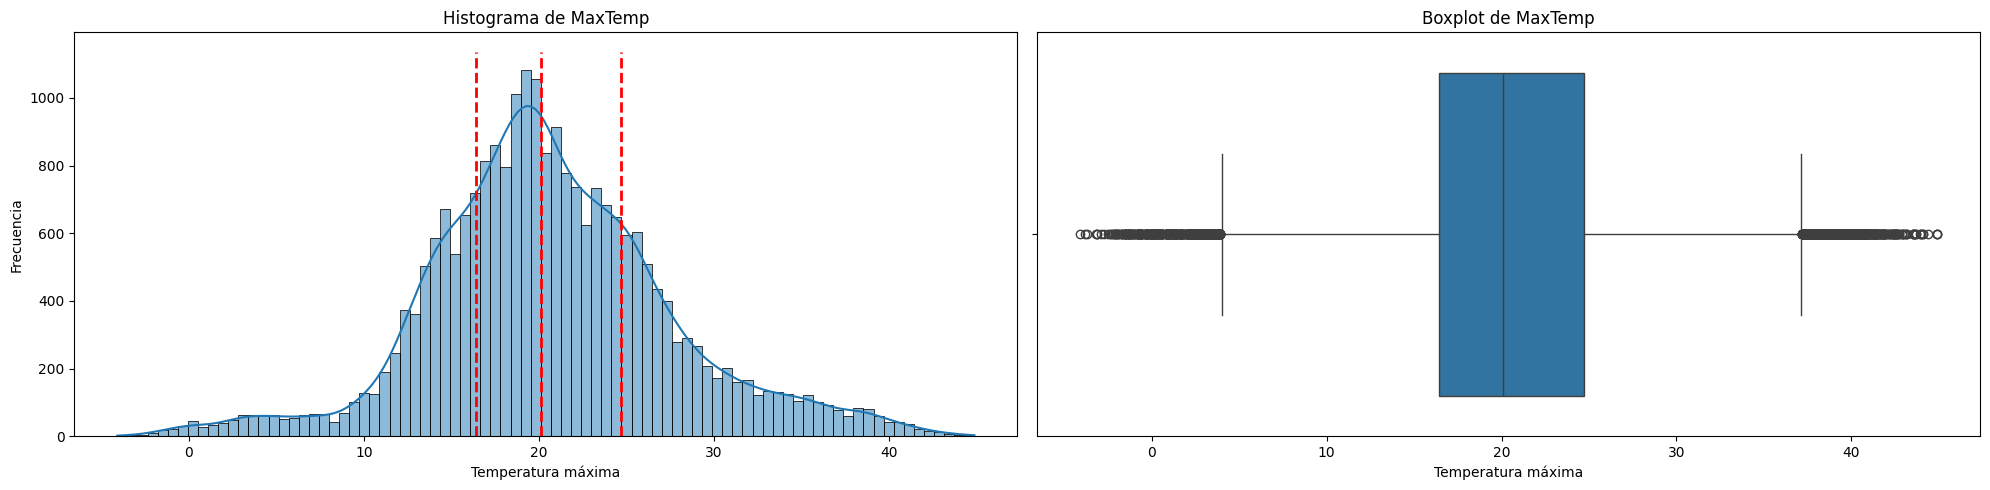

count    23490.000000
mean        20.658612
std          6.998124
min         -4.100000
25%         16.400000
50%         20.100000
75%         24.700000
max         44.900000
Name: MaxTemp, dtype: float64

In [23]:
fig, axs = plt.subplots(1, 2, figsize=(20, 5))

# Histograma
sns.histplot(train['MaxTemp'], kde=True, ax=axs[0])
axs[0].set_title('Histograma de MaxTemp')
axs[0].set_xlabel('Temperatura máxima')
axs[0].set_ylabel('Frecuencia')

# Calcular cuartiles
q1 = train['MaxTemp'].quantile(0.25)
q2 = train['MaxTemp'].quantile(0.5)
q3 = train['MaxTemp'].quantile(0.75)

# Agregue líneas de cuartil con ymin e ymax establecidos en todo el rango y del gráfico
axs[0].vlines([q1, q2, q3], color='red', linestyles='dashed', linewidths=2,
              ymin=axs[0].get_ylim()[0], ymax=axs[0].get_ylim()[1])

# Boxplot
sns.boxplot(x=train['MaxTemp'], ax=axs[1])
axs[1].set_title('Boxplot de MaxTemp')
axs[1].set_xlabel('Temperatura máxima')

plt.tight_layout()
plt.show()

train['MaxTemp'].describe()


La variable MaxTemp posee una distribución normal con sesgo a la derecha, predominando una temperatura maxima de 21° aproximadamente. La misma, tiene picos de 45° y minimos de 4°, pudiendo considerarse estos mismos como Outliers

### Rainfall

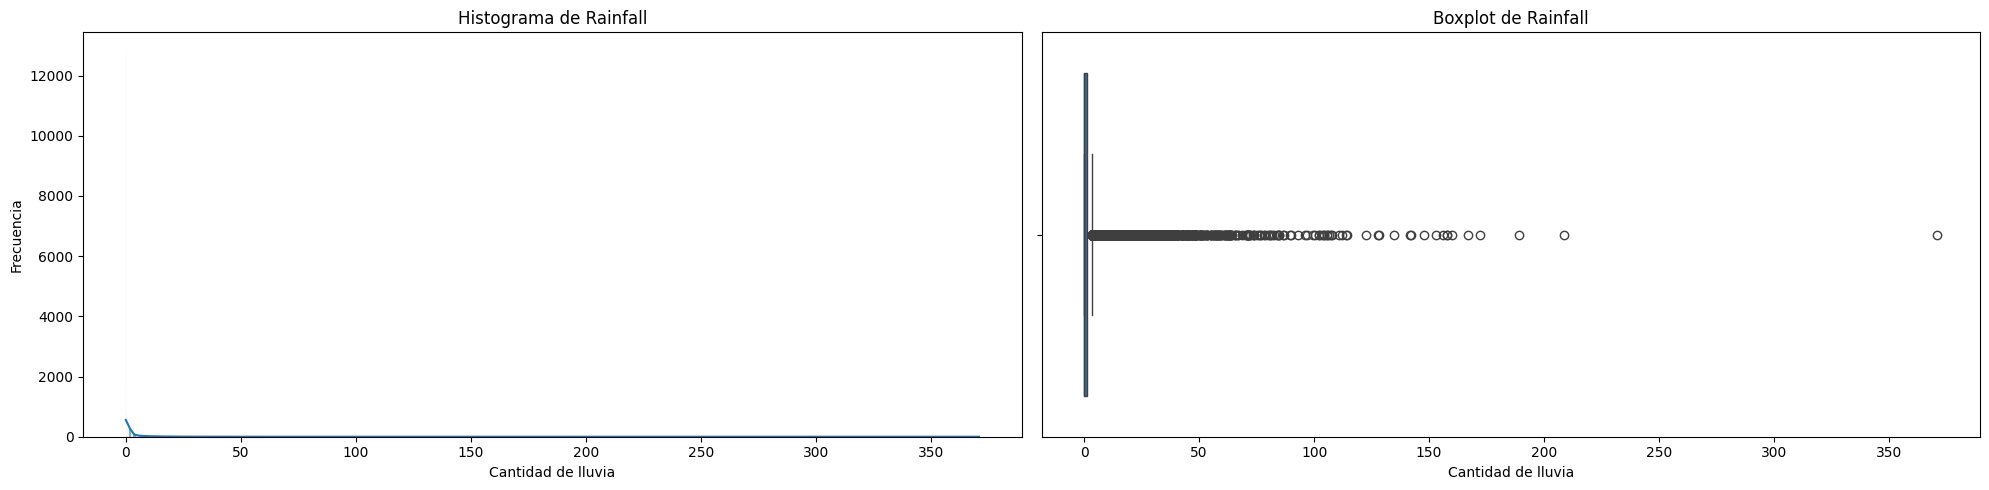

count    23186.000000
mean         2.743707
std          8.954942
min          0.000000
25%          0.000000
50%          0.000000
75%          1.400000
max        371.000000
Name: Rainfall, dtype: float64

In [24]:
fig, axs = plt.subplots(1, 2, figsize=(20, 5))

# Histograma
sns.histplot(train['Rainfall'], kde=True, ax=axs[0])
axs[0].set_title('Histograma de Rainfall')
axs[0].set_xlabel('Cantidad de lluvia')
axs[0].set_ylabel('Frecuencia')

# Boxplot
sns.boxplot(x=train['Rainfall'], ax=axs[1])
axs[1].set_title('Boxplot de Rainfall')
axs[1].set_xlabel('Cantidad de lluvia')

plt.tight_layout()
plt.show()

train['Rainfall'].describe()


### Evaporation

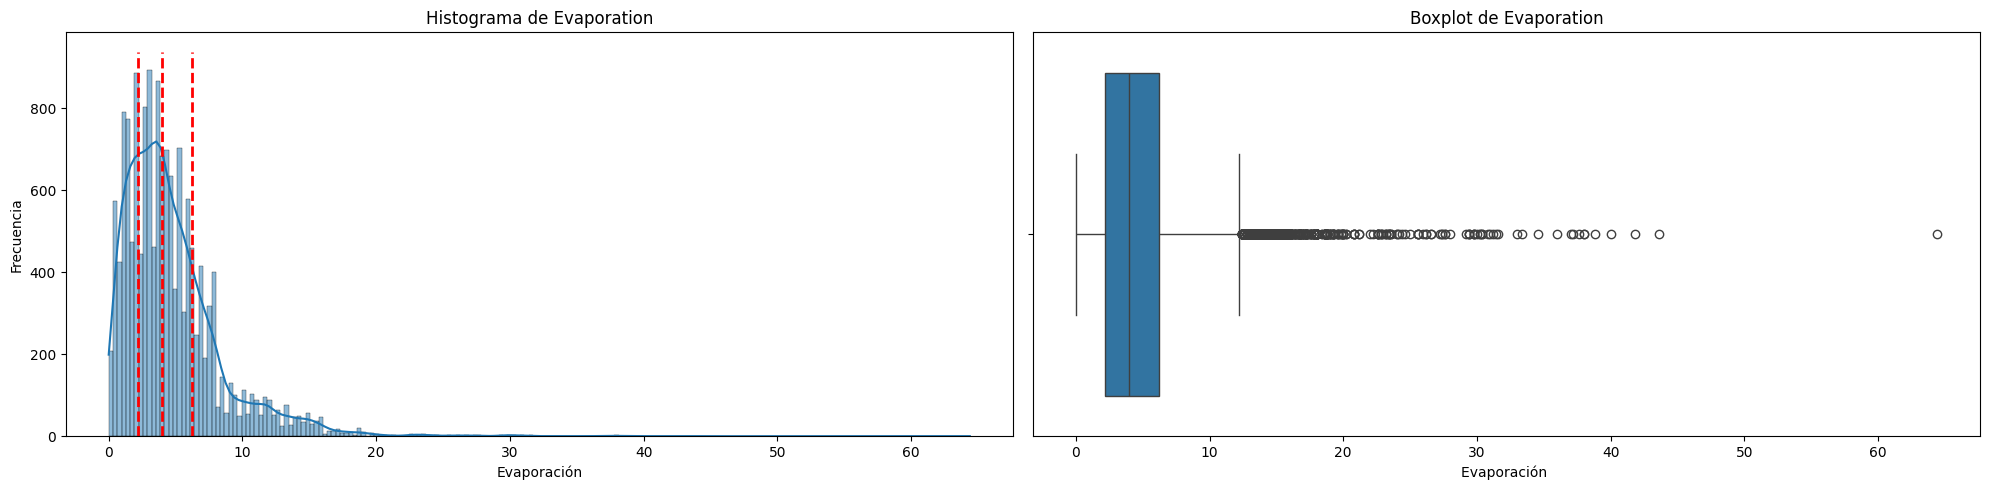

count    15490.000000
mean         4.739141
std          3.793528
min          0.000000
25%          2.200000
50%          4.000000
75%          6.200000
max         64.400000
Name: Evaporation, dtype: float64

In [25]:
fig, axs = plt.subplots(1, 2, figsize=(20, 5))

# Histograma
sns.histplot(train['Evaporation'], kde=True, ax=axs[0])

# Calcular cuartiles
q1 = train['Evaporation'].quantile(0.25)
q2 = train['Evaporation'].quantile(0.5)
q3 = train['Evaporation'].quantile(0.75)

# Agregue líneas de cuartil con ymin e ymax establecidos en todo el rango y del gráfico
axs[0].vlines([q1, q2, q3], color='red', linestyles='dashed', linewidths=2,
              ymin=axs[0].get_ylim()[0], ymax=axs[0].get_ylim()[1])

axs[0].set_title('Histograma de Evaporation')
axs[0].set_xlabel('Evaporación')
axs[0].set_ylabel('Frecuencia')

# Boxplot
sns.boxplot(x=train['Evaporation'], ax=axs[1])
axs[1].set_title('Boxplot de Evaporation')
axs[1].set_xlabel('Evaporación ')

plt.tight_layout()
plt.show()

train['Evaporation'].describe()



Como podemos ver, nuestra variable Evaporation tiene una gran cantidad de Outliers y muy distribuidos unos respectos de otros, con rango entre 15 y 45, los cuales debemos tener en cuenta a la hora del entrenamiento dado que si consideramos quitarlos, podríamos perder gran información valiosa.

### Sunshine

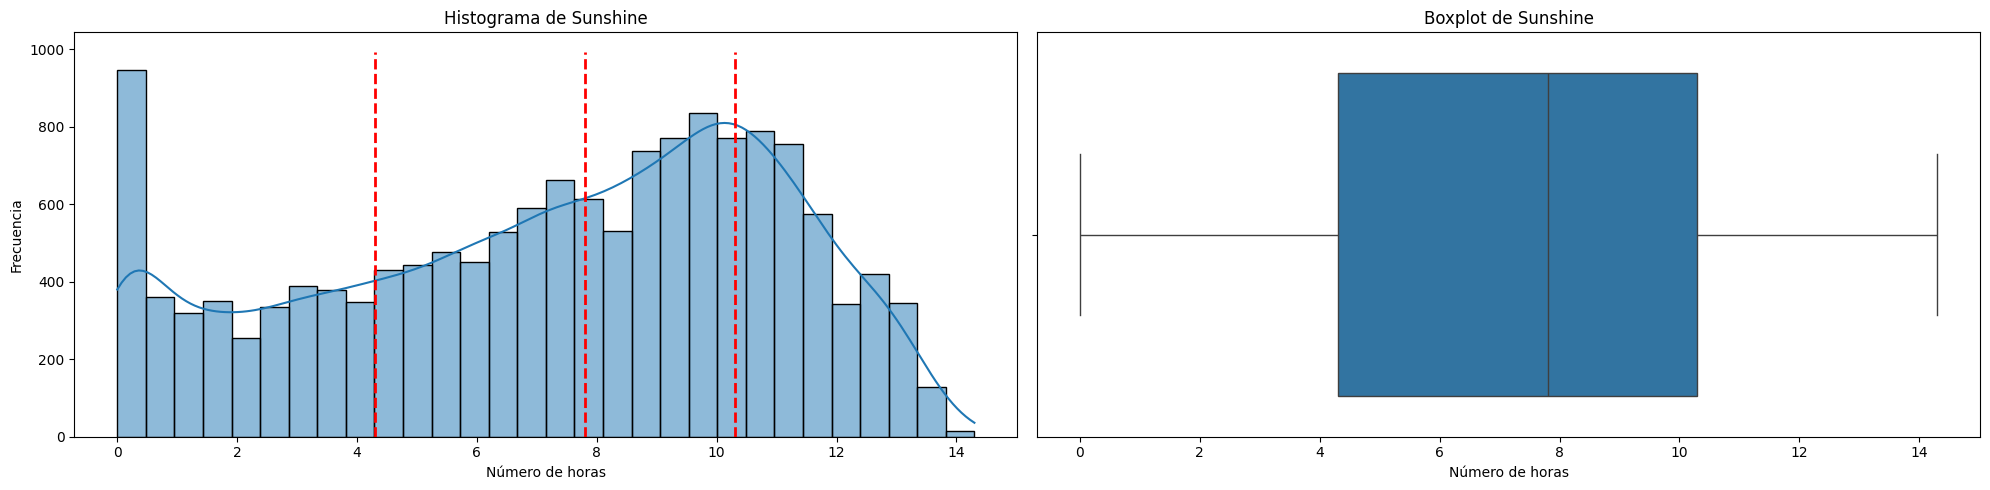

count    14901.000000
mean         7.191974
std          3.775942
min          0.000000
25%          4.300000
50%          7.800000
75%         10.300000
max         14.300000
Name: Sunshine, dtype: float64

In [26]:
fig, axs = plt.subplots(1, 2, figsize=(20, 5))

# Histograma
sns.histplot(train['Sunshine'], kde=True, ax=axs[0])
axs[0].set_title('Histograma de Sunshine')
axs[0].set_xlabel('Número de horas')
axs[0].set_ylabel('Frecuencia')

# Calcular cuartiles
q1 = train['Sunshine'].quantile(0.25)
q2 = train['Sunshine'].quantile(0.5)
q3 = train['Sunshine'].quantile(0.75)

# Agregue líneas de cuartil con ymin e ymax establecidos en todo el rango y del gráfico
axs[0].vlines([q1, q2, q3], color='red', linestyles='dashed', linewidths=2,
              ymin=axs[0].get_ylim()[0], ymax=axs[0].get_ylim()[1])

# Boxplot
sns.boxplot(x=train['Sunshine'], ax=axs[1])
axs[1].set_title('Boxplot de Sunshine')
axs[1].set_xlabel('Número de horas')

plt.tight_layout()
plt.show()

train['Sunshine'].describe()

### WindGustDir

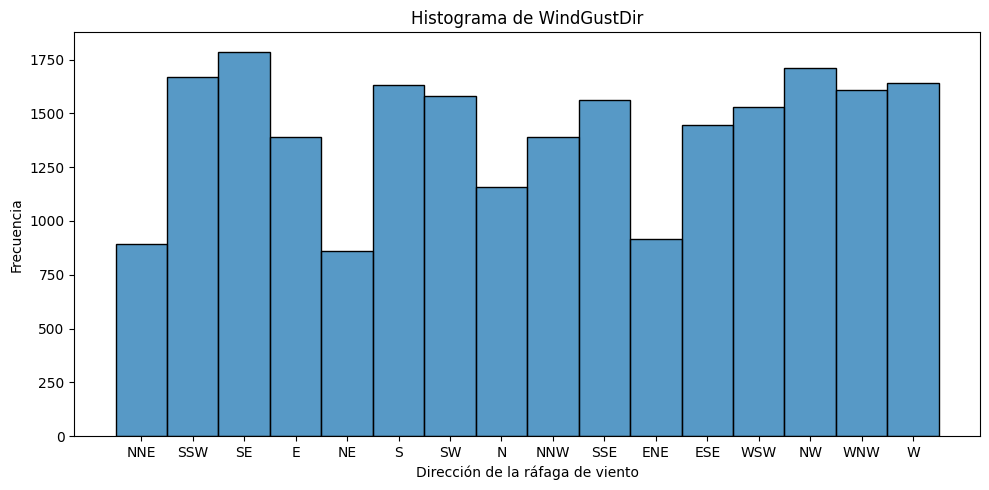

count     22776
unique       16
top          SE
freq       1787
Name: WindGustDir, dtype: object

In [27]:
fig, axs = plt.subplots(figsize=(10, 5))

# Histograma
sns.histplot(train['WindGustDir'])
axs.set_title('Histograma de WindGustDir')
axs.set_xlabel('Dirección de la ráfaga de viento')
axs.set_ylabel('Frecuencia')

plt.tight_layout()
plt.show()

train['WindGustDir'].describe()

### WindGustSpeed

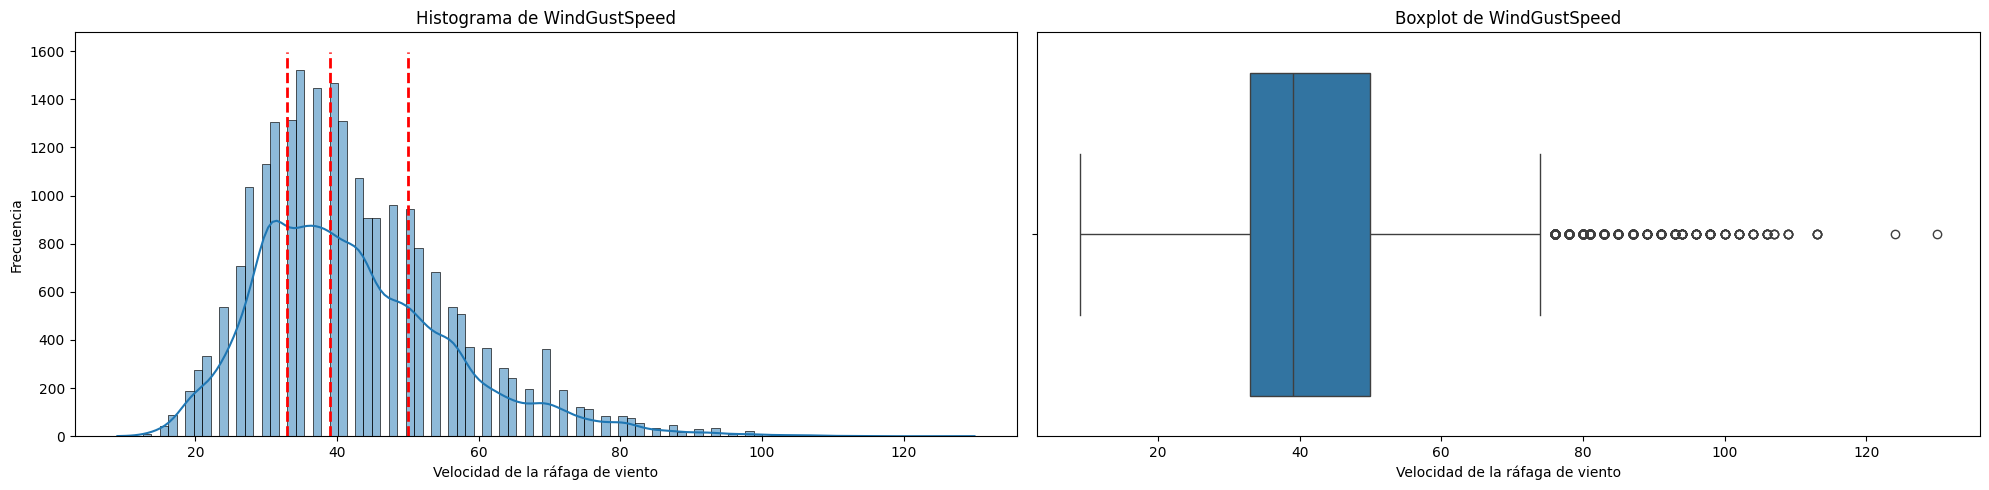

count    22810.000000
mean        42.362166
std         14.007494
min          9.000000
25%         33.000000
50%         39.000000
75%         50.000000
max        130.000000
Name: WindGustSpeed, dtype: float64

In [28]:

fig, axs = plt.subplots(1, 2, figsize=(20, 5))

# Histograma
sns.histplot(train['WindGustSpeed'], kde=True, ax=axs[0])
axs[0].set_title('Histograma de WindGustSpeed')
axs[0].set_xlabel('Velocidad de la ráfaga de viento')
axs[0].set_ylabel('Frecuencia')

# Calcular cuartiles
q1 = train['WindGustSpeed'].quantile(0.25)
q2 = train['WindGustSpeed'].quantile(0.5)
q3 = train['WindGustSpeed'].quantile(0.75)

# Agregue líneas de cuartil con ymin e ymax establecidos en todo el rango y del gráfico
axs[0].vlines([q1, q2, q3], color='red', linestyles='dashed', linewidths=2,
              ymin=axs[0].get_ylim()[0], ymax=axs[0].get_ylim()[1])

# Boxplot
sns.boxplot(x=train['WindGustSpeed'], ax=axs[1])
axs[1].set_title('Boxplot de WindGustSpeed')
axs[1].set_xlabel('Velocidad de la ráfaga de viento')

plt.tight_layout()
plt.show()
train['WindGustSpeed'].describe()

### WindDir9am

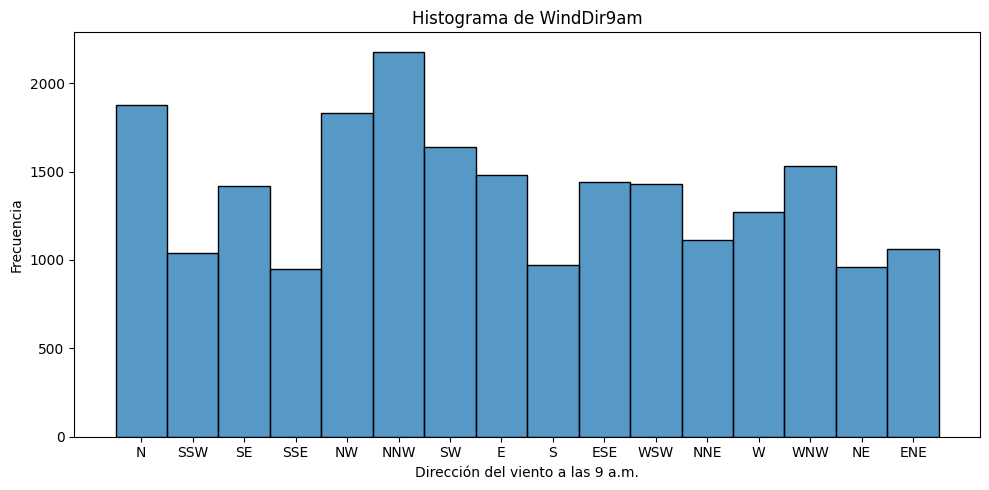

count     22200
unique       16
top         NNW
freq       2179
Name: WindDir9am, dtype: object

In [29]:
fig, axs = plt.subplots(figsize=(10, 5))

# Histograma
sns.histplot(train['WindDir9am'])
axs.set_title('Histograma de WindDir9am')
axs.set_xlabel('Dirección del viento a las 9 a.m.')
axs.set_ylabel('Frecuencia')

plt.tight_layout()
plt.show()

train['WindDir9am'].describe()

### WindDir3pm

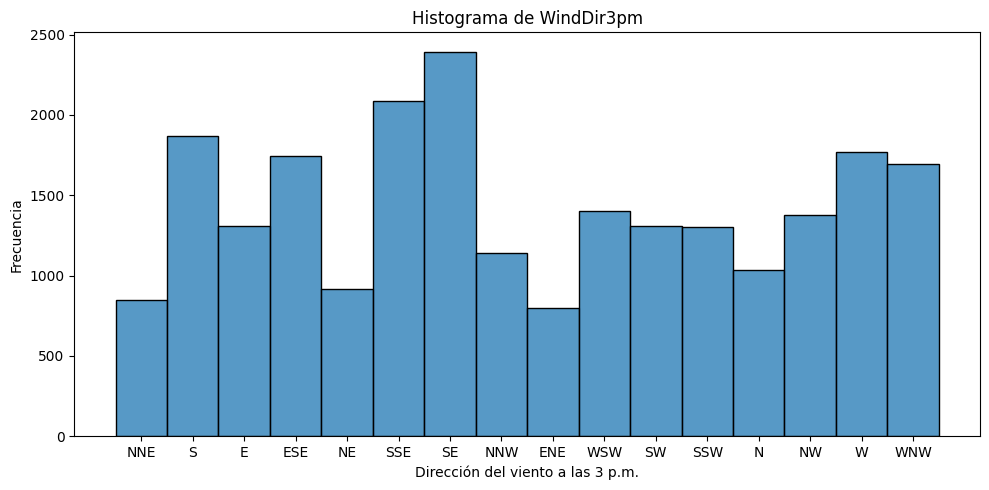

count     22990
unique       16
top          SE
freq       2394
Name: WindDir3pm, dtype: object

In [30]:
fig, axs = plt.subplots(figsize=(10, 5))

# Histograma
sns.histplot(train['WindDir3pm'])
axs.set_title('Histograma de WindDir3pm')
axs.set_xlabel('Dirección del viento a las 3 p.m.')
axs.set_ylabel('Frecuencia')

plt.tight_layout()
plt.show()

train['WindDir3pm'].describe()

### WindSpeed9am

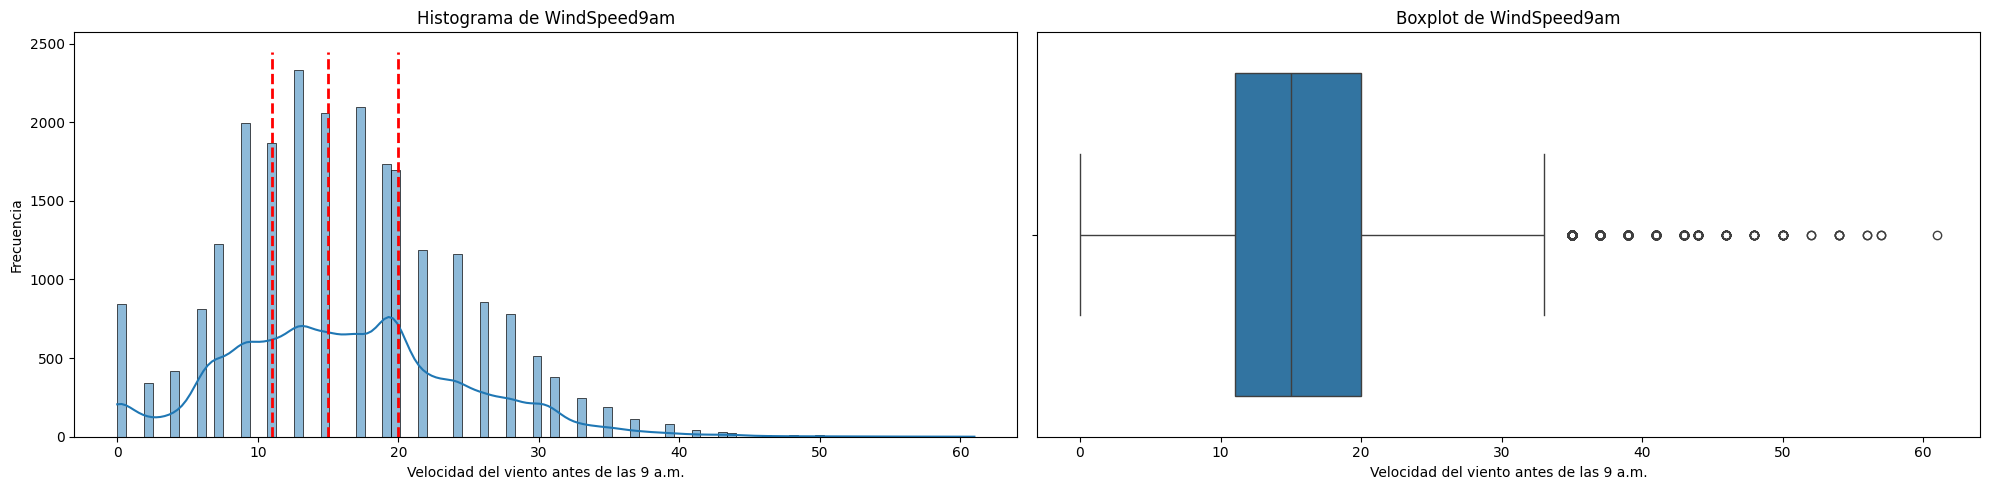

In [31]:
fig, axs = plt.subplots(1, 2, figsize=(20, 5))

# Histograma
sns.histplot(train['WindSpeed9am'], kde=True, ax=axs[0])
axs[0].set_title('Histograma de WindSpeed9am')
axs[0].set_xlabel('Velocidad del viento antes de las 9 a.m.')
axs[0].set_ylabel('Frecuencia')

# Calcular cuartiles
q1 = train['WindSpeed9am'].quantile(0.25)
q2 = train['WindSpeed9am'].quantile(0.5)
q3 = train['WindSpeed9am'].quantile(0.75)

# Agregue líneas de cuartil con ymin e ymax establecidos en todo el rango y del gráfico
axs[0].vlines([q1, q2, q3], color='red', linestyles='dashed', linewidths=2,
              ymin=axs[0].get_ylim()[0], ymax=axs[0].get_ylim()[1])

# Boxplot
sns.boxplot(x=train['WindSpeed9am'], ax=axs[1])
axs[1].set_title('Boxplot de WindSpeed9am')
axs[1].set_xlabel('Velocidad del viento antes de las 9 a.m.')

plt.tight_layout()
plt.show()


### WindSpeed3pm

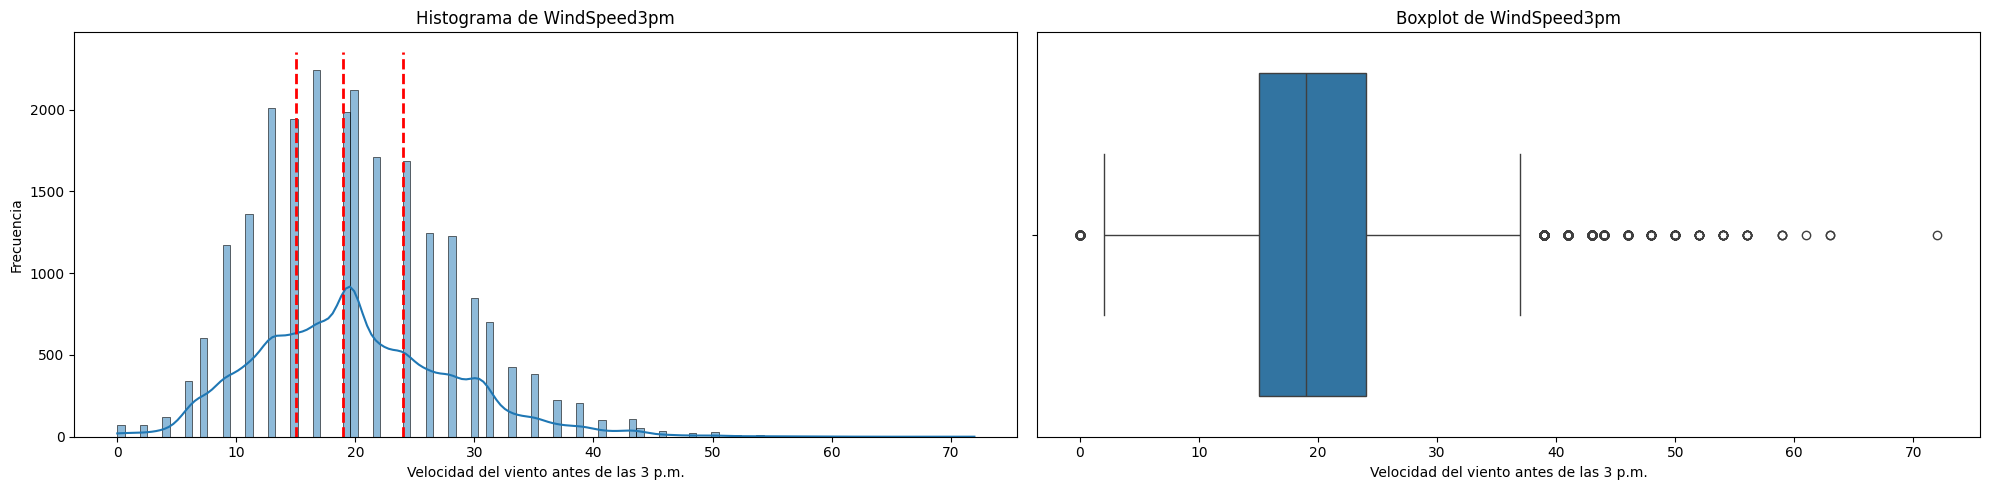

count    23094.000000
mean        19.877457
std          8.166185
min          0.000000
25%         15.000000
50%         19.000000
75%         24.000000
max         72.000000
Name: WindSpeed3pm, dtype: float64

In [32]:
fig, axs = plt.subplots(1, 2, figsize=(20, 5))

# Histograma
sns.histplot(train['WindSpeed3pm'], kde=True, ax=axs[0])
axs[0].set_title('Histograma de WindSpeed3pm')
axs[0].set_xlabel('Velocidad del viento antes de las 3 p.m.')
axs[0].set_ylabel('Frecuencia')


# Calcular cuartiles
q1 = train['WindSpeed3pm'].quantile(0.25)
q2 = train['WindSpeed3pm'].quantile(0.5)
q3 = train['WindSpeed3pm'].quantile(0.75)

# Agregue líneas de cuartil con ymin e ymax establecidos en todo el rango y del gráfico
axs[0].vlines([q1, q2, q3], color='red', linestyles='dashed', linewidths=2,
              ymin=axs[0].get_ylim()[0], ymax=axs[0].get_ylim()[1])

# Boxplot
sns.boxplot(x=train['WindSpeed3pm'], ax=axs[1])
axs[1].set_title('Boxplot de WindSpeed3pm')
axs[1].set_xlabel('Velocidad del viento antes de las 3 p.m.')

plt.tight_layout()
plt.show()

train['WindSpeed3pm'].describe()

### Humidity9am

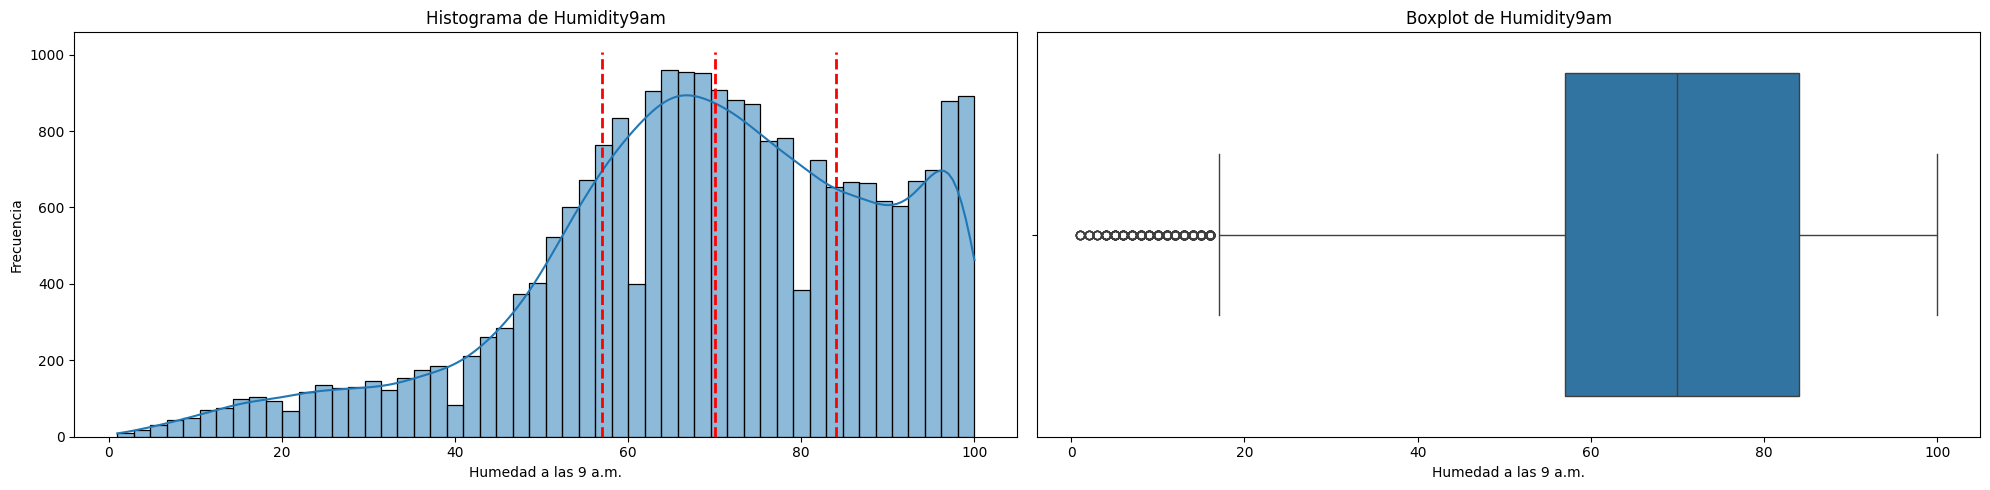

In [33]:
fig, axs = plt.subplots(1, 2, figsize=(20, 5))

# Histograma
sns.histplot(train['Humidity9am'], kde=True, ax=axs[0])
axs[0].set_title('Histograma de Humidity9am')
axs[0].set_xlabel('Humedad a las 9 a.m.')
axs[0].set_ylabel('Frecuencia')


# Calcular cuartiles
q1 = train['Humidity9am'].quantile(0.25)
q2 = train['Humidity9am'].quantile(0.5)
q3 = train['Humidity9am'].quantile(0.75)

# Agregue líneas de cuartil con ymin e ymax establecidos en todo el rango y del gráfico
axs[0].vlines([q1, q2, q3], color='red', linestyles='dashed', linewidths=2,
              ymin=axs[0].get_ylim()[0], ymax=axs[0].get_ylim()[1])

# Boxplot
sns.boxplot(x=train['Humidity9am'], ax=axs[1])
axs[1].set_title('Boxplot de Humidity9am')
axs[1].set_xlabel('Humedad a las 9 a.m.')

plt.tight_layout()
plt.show()



### Humidity3pm

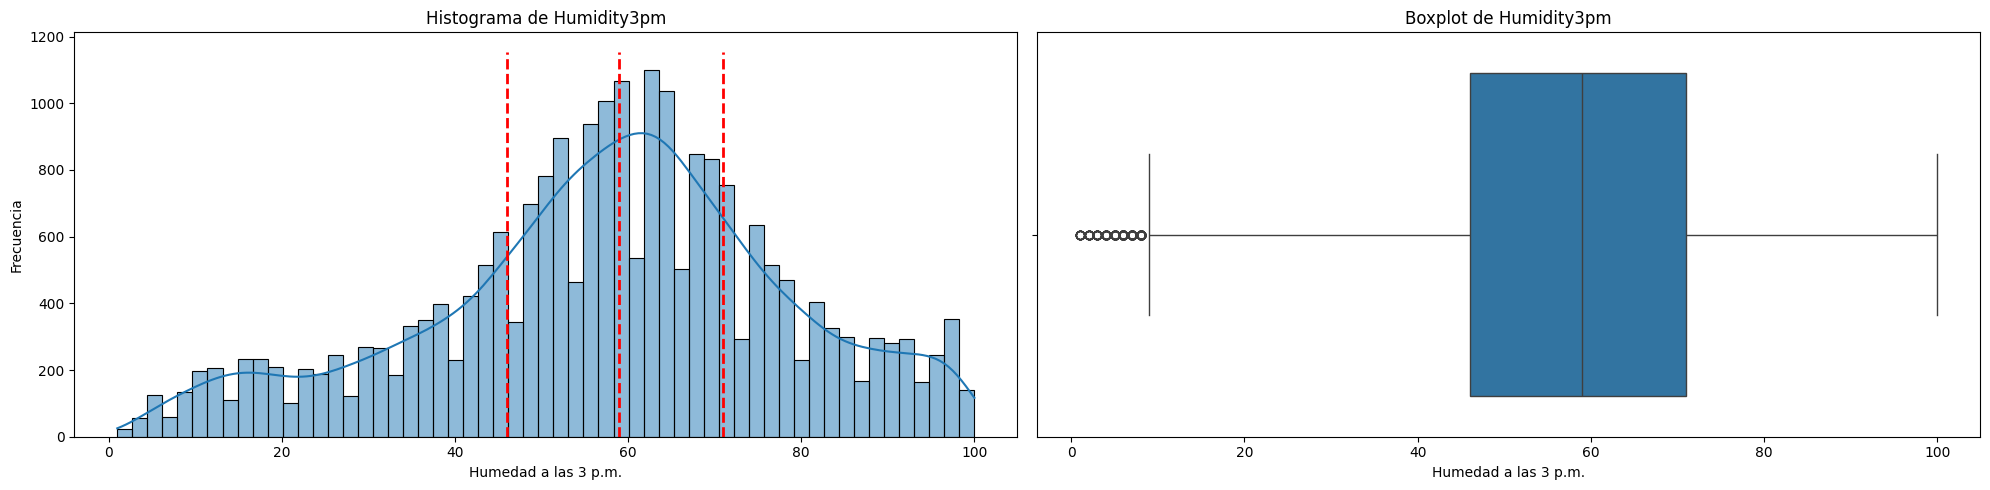

In [34]:
fig, axs = plt.subplots(1, 2, figsize=(20, 5))

# Histograma
sns.histplot(train['Humidity3pm'], kde=True, ax=axs[0])
axs[0].set_title('Histograma de Humidity3pm')
axs[0].set_xlabel('Humedad a las 3 p.m.')
axs[0].set_ylabel('Frecuencia')


# Calcular cuartiles
q1 = train['Humidity3pm'].quantile(0.25)
q2 = train['Humidity3pm'].quantile(0.5)
q3 = train['Humidity3pm'].quantile(0.75)

# Agregue líneas de cuartil con ymin e ymax establecidos en todo el rango y del gráfico
axs[0].vlines([q1, q2, q3], color='red', linestyles='dashed', linewidths=2,
              ymin=axs[0].get_ylim()[0], ymax=axs[0].get_ylim()[1])

# Boxplot
sns.boxplot(x=train['Humidity3pm'], ax=axs[1])
axs[1].set_title('Boxplot de Humidity3pm')
axs[1].set_xlabel('Humedad a las 3 p.m.')

plt.tight_layout()
plt.show()


### Pressure9am

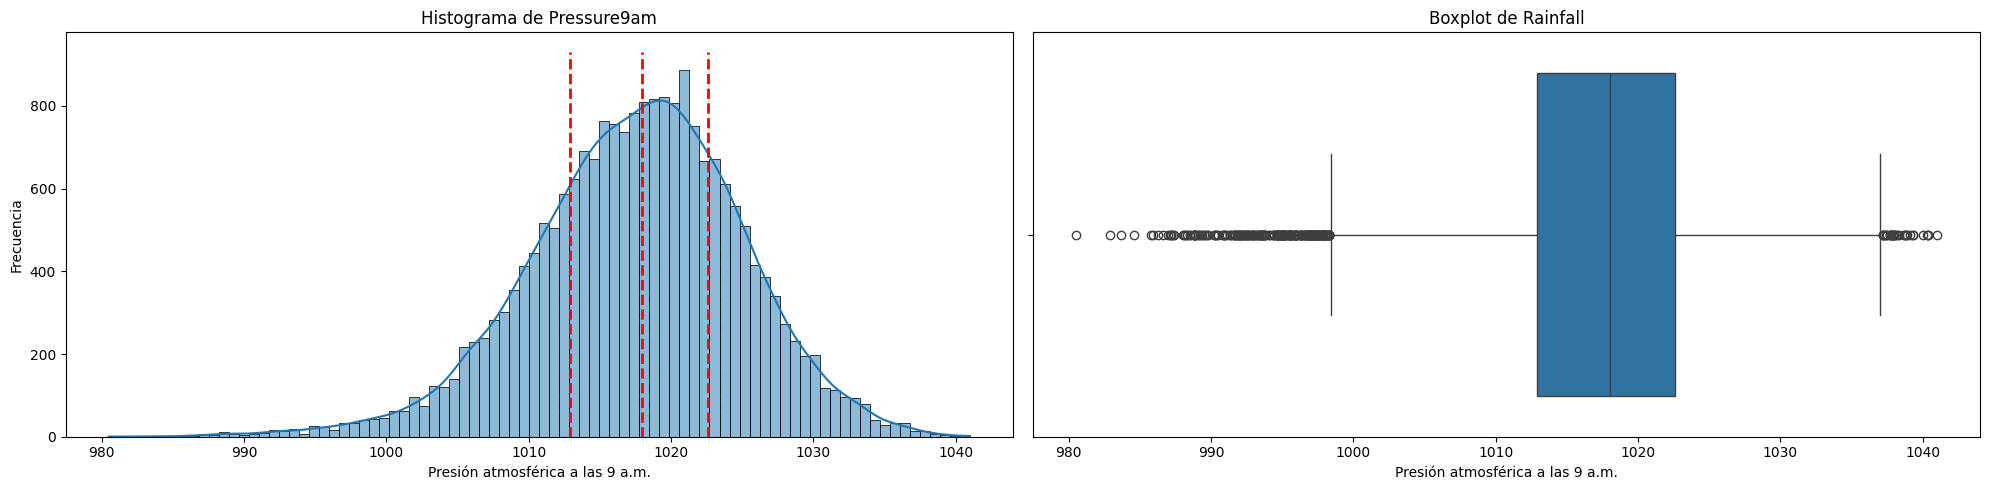

In [35]:
fig, axs = plt.subplots(1, 2, figsize=(20, 5))

# Histograma
sns.histplot(train['Pressure9am'], kde=True, ax=axs[0])

axs[0].set_title('Histograma de Pressure9am')
axs[0].set_xlabel('Presión atmosférica a las 9 a.m.')
axs[0].set_ylabel('Frecuencia')


# Calcular cuartiles
q1 = train['Pressure9am'].quantile(0.25)
q2 = train['Pressure9am'].quantile(0.5)
q3 = train['Pressure9am'].quantile(0.75)

# Agregue líneas de cuartil con ymin e ymax establecidos en todo el rango y del gráfico
axs[0].vlines([q1, q2, q3], color='red', linestyles='dashed', linewidths=2,
              ymin=axs[0].get_ylim()[0], ymax=axs[0].get_ylim()[1])

# Boxplot
sns.boxplot(x=train['Pressure9am'], ax=axs[1])
axs[1].set_title('Boxplot de Rainfall')
axs[1].set_xlabel('Presión atmosférica a las 9 a.m.')

plt.tight_layout()
plt.show()



### Pressure3pm

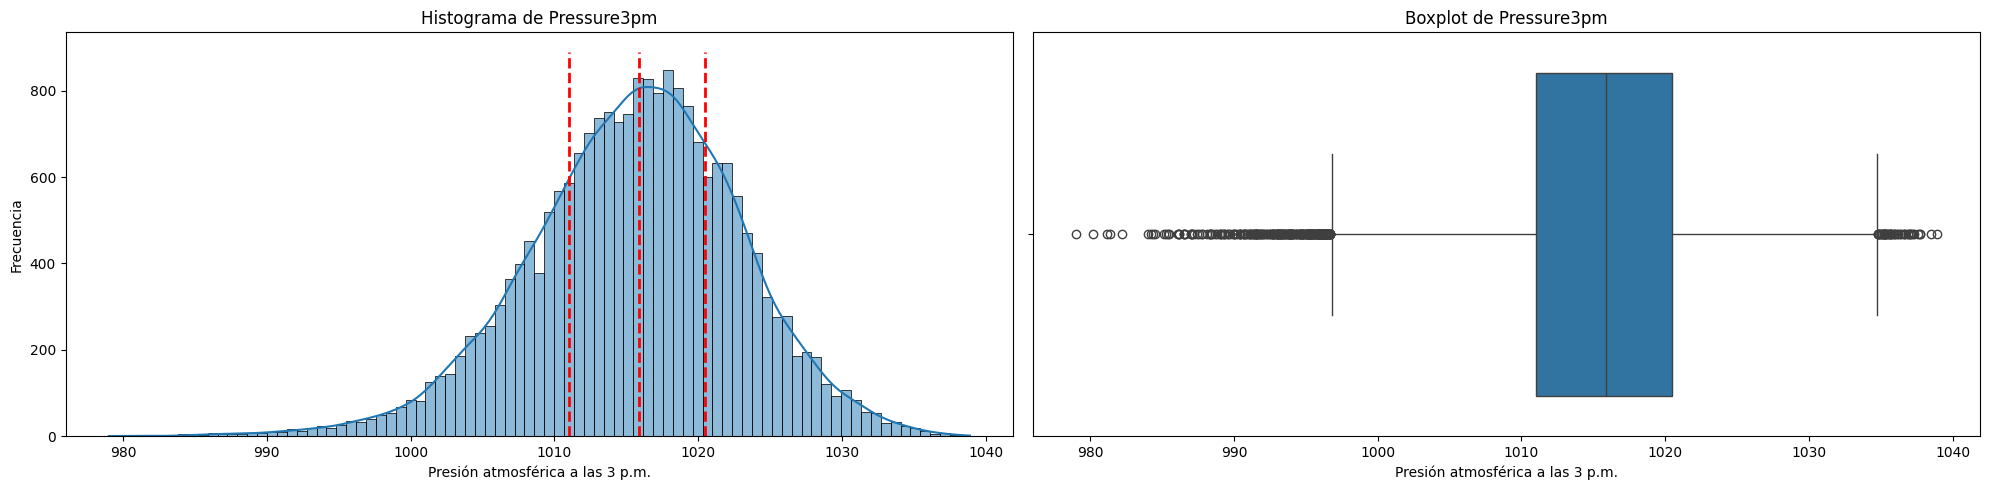

In [36]:
fig, axs = plt.subplots(1, 2, figsize=(20, 5))

# Histograma
sns.histplot(train['Pressure3pm'], kde=True, ax=axs[0])
axs[0].set_title('Histograma de Pressure3pm')
axs[0].set_xlabel('Presión atmosférica a las 3 p.m.')
axs[0].set_ylabel('Frecuencia')

# Calcular cuartiles
q1 = train['Pressure3pm'].quantile(0.25)
q2 = train['Pressure3pm'].quantile(0.5)
q3 = train['Pressure3pm'].quantile(0.75)

# Agregue líneas de cuartil con ymin e ymax establecidos en todo el rango y del gráfico
axs[0].vlines([q1, q2, q3], color='red', linestyles='dashed', linewidths=2,
              ymin=axs[0].get_ylim()[0], ymax=axs[0].get_ylim()[1])

# Boxplot
sns.boxplot(x=train['Pressure3pm'], ax=axs[1])
axs[1].set_title('Boxplot de Pressure3pm')
axs[1].set_xlabel('Presión atmosférica a las 3 p.m.')

plt.tight_layout()
plt.show()



### Cloud9am

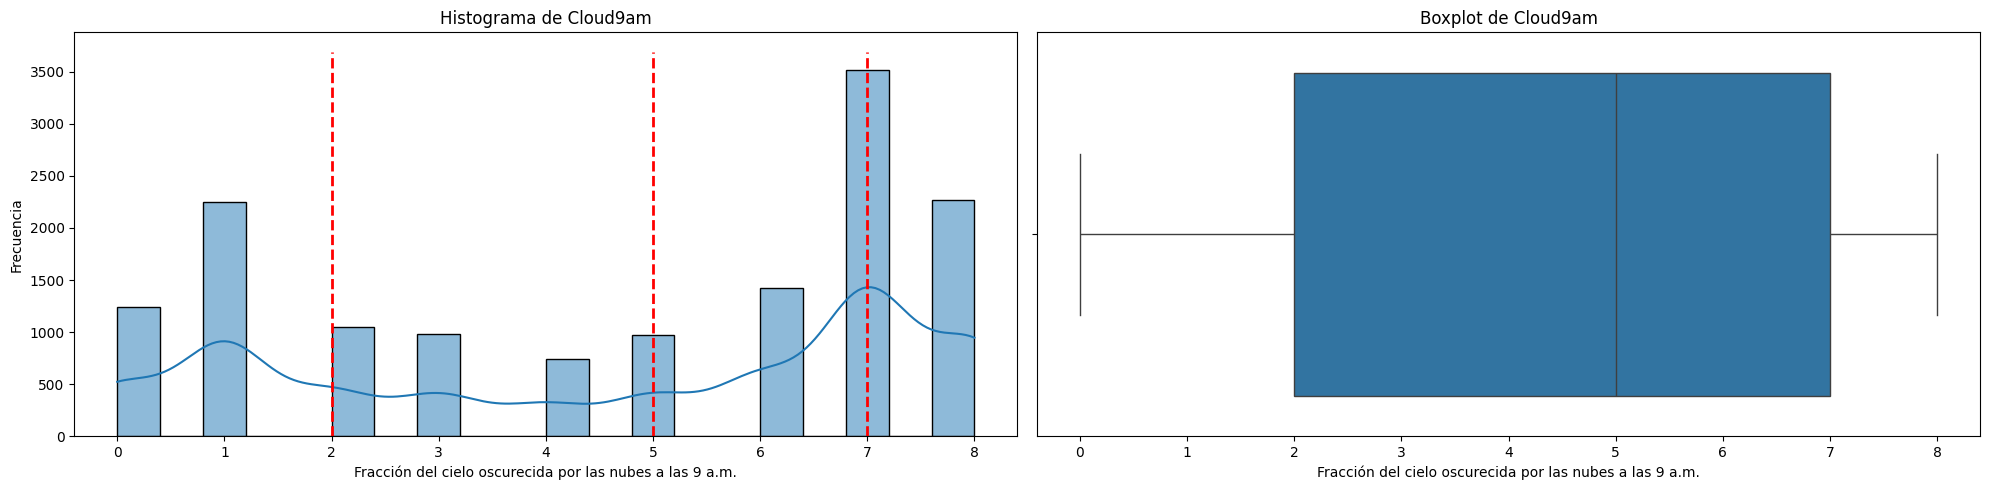

In [37]:
fig, axs = plt.subplots(1, 2, figsize=(20, 5))


# Histograma
sns.histplot(train['Cloud9am'], kde=True, ax=axs[0])
axs[0].set_title('Histograma de Cloud9am')
axs[0].set_xlabel('Fracción del cielo oscurecida por las nubes a las 9 a.m.')
axs[0].set_ylabel('Frecuencia')

# Calcular cuartiles
q1 = train['Cloud9am'].quantile(0.25)
q2 = train['Cloud9am'].quantile(0.5)
q3 = train['Cloud9am'].quantile(0.75)


# Agregue líneas de cuartil con ymin e ymax establecidos en todo el rango y del gráfico
axs[0].vlines([q1, q2, q3], color='red', linestyles='dashed', linewidths=2,
              ymin=axs[0].get_ylim()[0], ymax=axs[0].get_ylim()[1])

# Boxplot
sns.boxplot(x=train['Cloud9am'], ax=axs[1])
axs[1].set_title('Boxplot de Cloud9am')
axs[1].set_xlabel('Fracción del cielo oscurecida por las nubes a las 9 a.m.')

plt.tight_layout()
plt.show()



### Cloud3pm

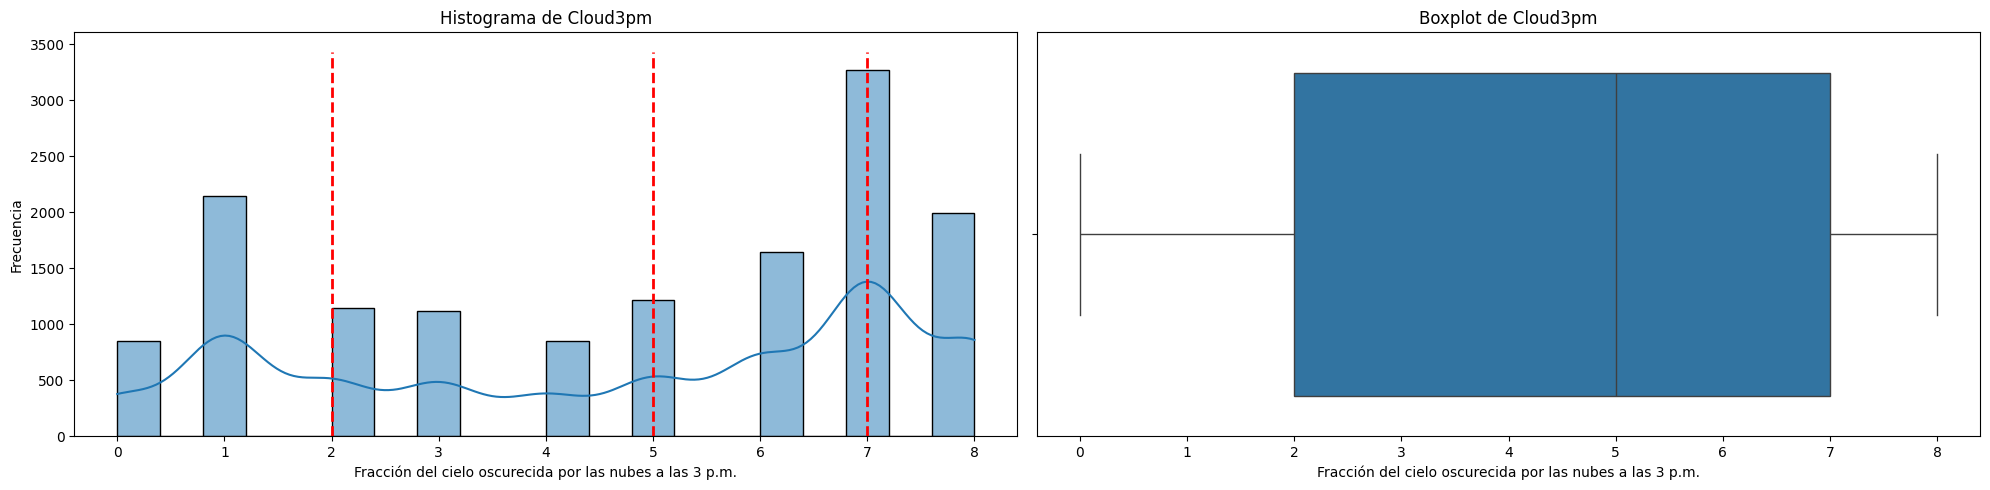

count    14230.000000
mean         4.637526
std          2.675906
min          0.000000
25%          2.000000
50%          5.000000
75%          7.000000
max          8.000000
Name: Cloud3pm, dtype: float64

In [38]:
fig, axs = plt.subplots(1, 2, figsize=(20, 5))

# Histograma
sns.histplot(train['Cloud3pm'], kde=True, ax=axs[0])
axs[0].set_title('Histograma de Cloud3pm')
axs[0].set_xlabel('Fracción del cielo oscurecida por las nubes a las 3 p.m.')
axs[0].set_ylabel('Frecuencia')

# Calcular cuartiles
q1 = train['Cloud3pm'].quantile(0.25)
q2 = train['Cloud3pm'].quantile(0.5)
q3 = train['Cloud3pm'].quantile(0.75)

# Agregue líneas de cuartil con ymin e ymax establecidos en todo el rango y del gráfico
axs[0].vlines([q1, q2, q3], color='red', linestyles='dashed', linewidths=2,
              ymin=axs[0].get_ylim()[0], ymax=axs[0].get_ylim()[1])

# Boxplot
sns.boxplot(x=train['Cloud3pm'], ax=axs[1])
axs[1].set_title('Boxplot de Cloud3pm')
axs[1].set_xlabel('Fracción del cielo oscurecida por las nubes a las 3 p.m.')

plt.tight_layout()
plt.show()

train['Cloud3pm'].describe()

### Temp9am

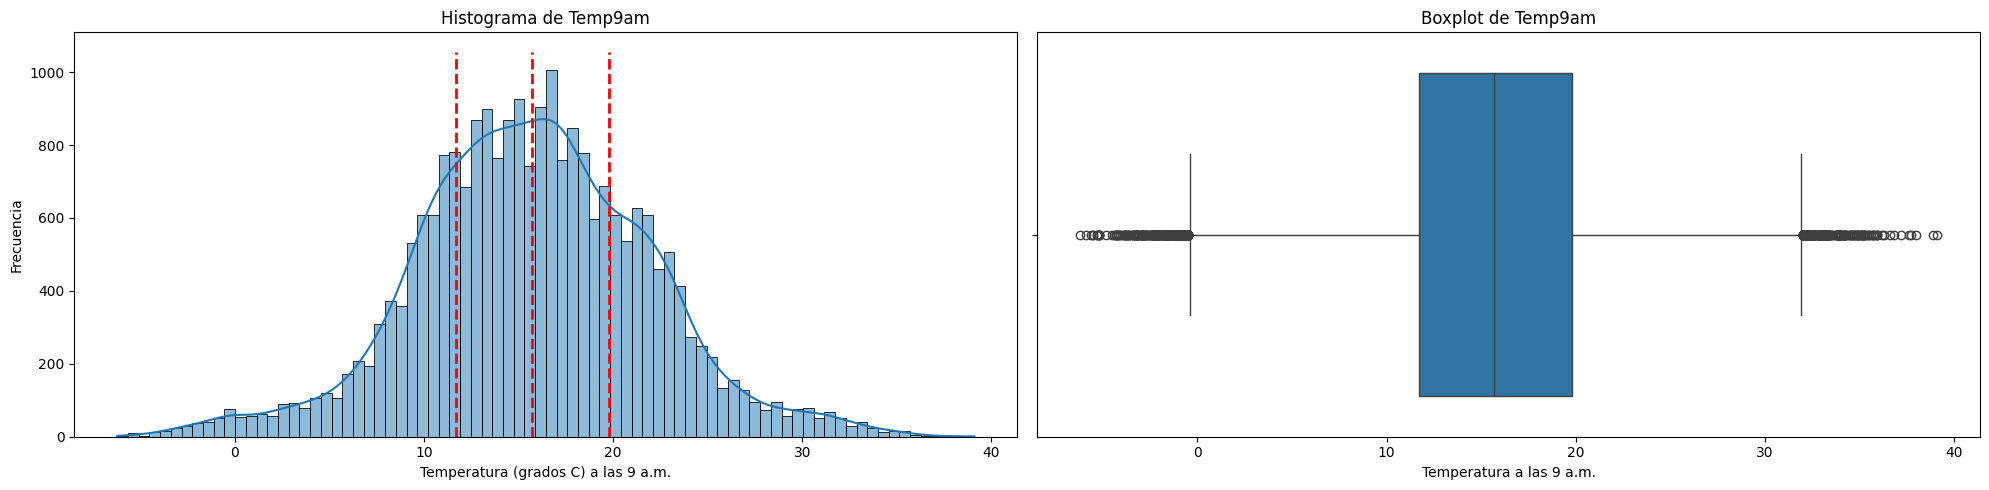

count    23096.000000
mean        15.750905
std          6.220593
min         -6.200000
25%         11.700000
50%         15.700000
75%         19.800000
max         39.100000
Name: Temp9am, dtype: float64

In [39]:
fig, axs = plt.subplots(1, 2, figsize=(20, 5))

# Histograma
sns.histplot(train['Temp9am'], kde=True, ax=axs[0])
axs[0].set_title('Histograma de Temp9am')
axs[0].set_xlabel('Temperatura (grados C) a las 9 a.m.')
axs[0].set_ylabel('Frecuencia')

# Calcular cuartiles
q1 = train['Temp9am'].quantile(0.25)
q2 = train['Temp9am'].quantile(0.5)
q3 = train['Temp9am'].quantile(0.75)

# Agregue líneas de cuartil con ymin e ymax establecidos en todo el rango y del gráfico
axs[0].vlines([q1, q2, q3], color='red', linestyles='dashed', linewidths=2,
              ymin=axs[0].get_ylim()[0], ymax=axs[0].get_ylim()[1])

# Boxplot
sns.boxplot(x=train['Temp9am'], ax=axs[1])
axs[1].set_title('Boxplot de Temp9am')
axs[1].set_xlabel('Temperatura a las 9 a.m.')

plt.tight_layout()
plt.show()

train['Temp9am'].describe()

### Temp3pm

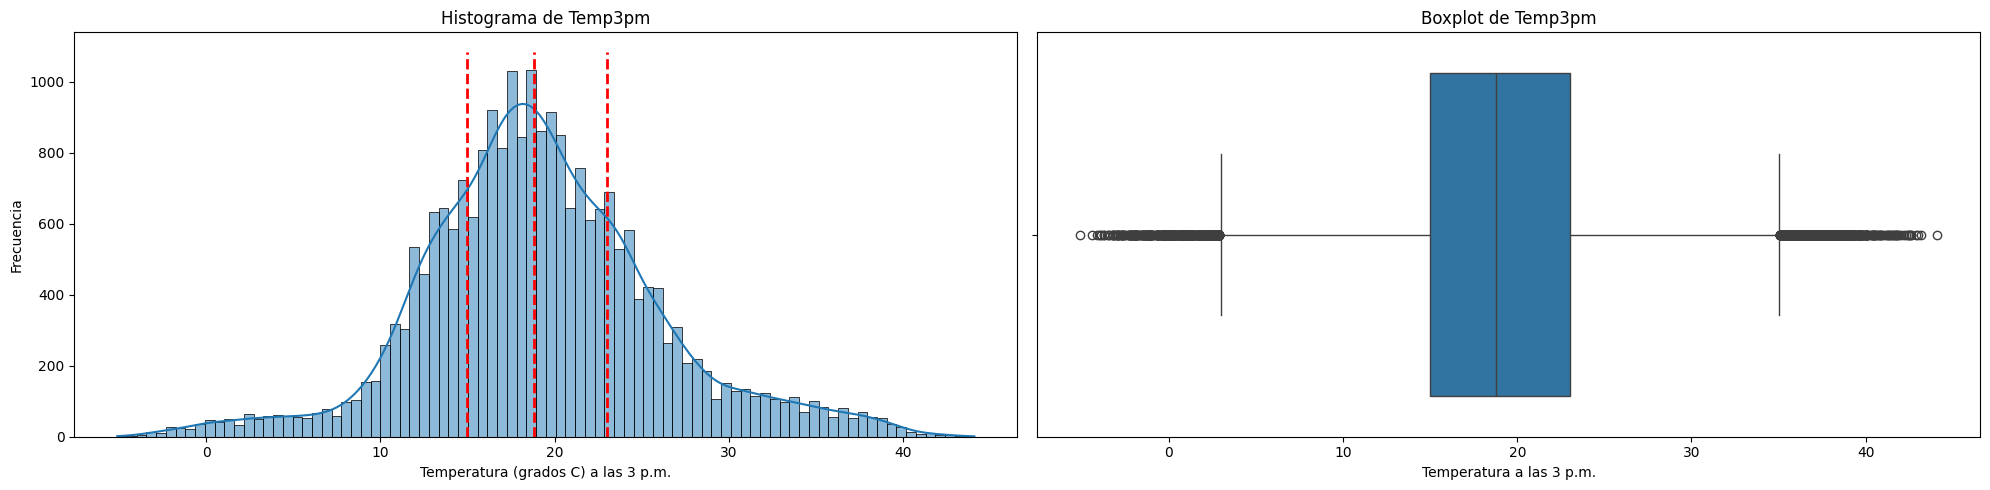

count    23256.000000
mean        19.173865
std          6.844022
min         -5.100000
25%         15.000000
50%         18.800000
75%         23.000000
max         44.100000
Name: Temp3pm, dtype: float64

In [40]:
fig, axs = plt.subplots(1, 2, figsize=(20, 5))


# Histograma
sns.histplot(train['Temp3pm'], kde=True, ax=axs[0])
axs[0].set_title('Histograma de Temp3pm')
axs[0].set_xlabel('Temperatura (grados C) a las 3 p.m.')
axs[0].set_ylabel('Frecuencia')

# Calcular cuartiles
q1 = train['Temp3pm'].quantile(0.25)
q2 = train['Temp3pm'].quantile(0.5)
q3 = train['Temp3pm'].quantile(0.75)

# Agregue líneas de cuartil con ymin e ymax establecidos en todo el rango y del gráfico
axs[0].vlines([q1, q2, q3], color='red', linestyles='dashed', linewidths=2,
              ymin=axs[0].get_ylim()[0], ymax=axs[0].get_ylim()[1])

# Boxplot
sns.boxplot(x=train['Temp3pm'], ax=axs[1])
axs[1].set_title('Boxplot de Temp3pm')
axs[1].set_xlabel('Temperatura a las 3 p.m.')

plt.tight_layout()
plt.show()

train['Temp3pm'].describe()

### RainToday

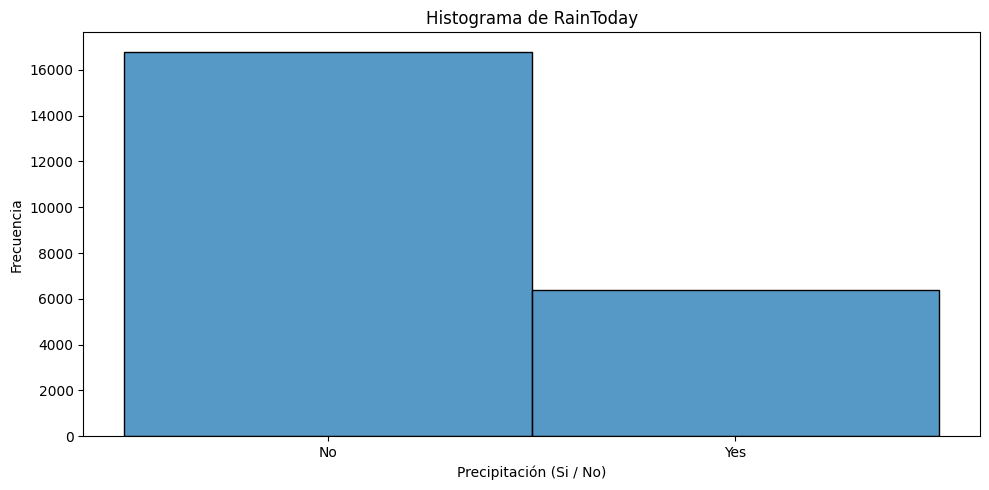

count     23186
unique        2
top          No
freq      16798
Name: RainToday, dtype: object

In [41]:
fig, axs = plt.subplots(figsize=(10, 5))

# Histograma
sns.histplot(train['RainToday'])
axs.set_title('Histograma de RainToday')
axs.set_xlabel('Precipitación (Si / No)')
axs.set_ylabel('Frecuencia')

plt.tight_layout()
plt.show()

train['RainToday'].describe()

### RainTomorrow

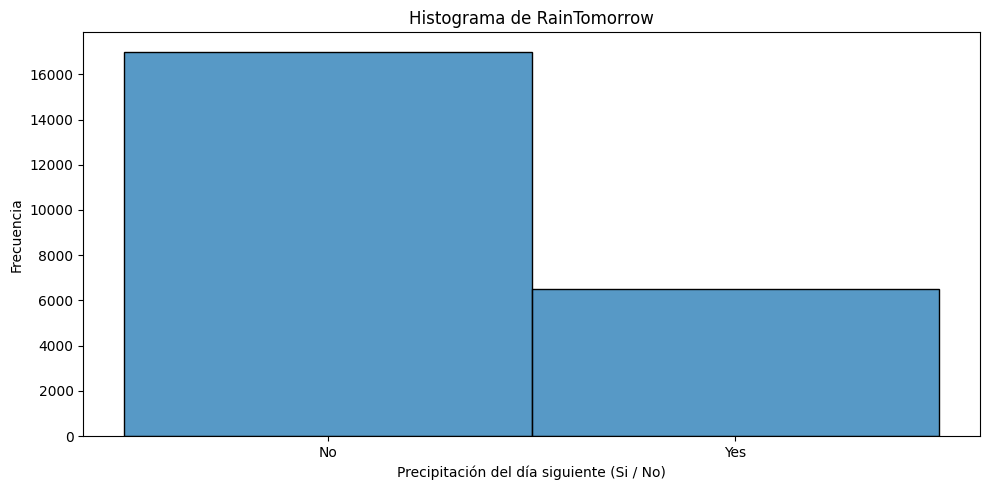

count     23520
unique        2
top          No
freq      17003
Name: RainTomorrow, dtype: object

In [42]:
fig, axs = plt.subplots(figsize=(10, 5))

# Histograma
sns.histplot(train['RainTomorrow'])
axs.set_title('Histograma de RainTomorrow')
axs.set_xlabel('Precipitación del día siguiente (Si / No)')
axs.set_ylabel('Frecuencia')

plt.tight_layout()
plt.show()

train['RainTomorrow'].describe()

### Analisis y observaciones luego de la vizualisacion de los datos

Las siguientes caracteristicas presentan valores atípicos: , **MinTemp**, **MaxTemp**, **Rainfall**, **Evaporation**, **WindGustSpeed**, **WindSpeed9am**, ****, **WindSpeed3pm**, **Humidity9am**, **Pressure9am**, **Pressure3pm**, **Temp9am** y **Temp3pm**.

Los valores atípicos pueden sesgar los parámetros del modelo al desviar la línea de regresión, afectando la relación general entre las variables. Podemos optar por tratarlos o no. Si decidimos tratarlos, debemos hacer una excepción con la columna RainTomorrow, que es la variable objetivo, y limitar la eliminación de outliers a un máximo del 10% del total de datos para evitar la pérdida de información valiosa y sesgar los resultados del modelo.

- Date: Fecha de observación.

        Debemos eliminarla porque no contiene información relevante.
        
- Location: El nombre de la ubicación de la estación meteorológica.

        Debemos descartar todas las ubicaciones que no nos interesen y luego las restantes asumirlas como una misma y única, para poder posteriormente eliminar Location y reducir la dimensionalidad para un modelo más simple.

- MinTemp: La temperatura mínima (°C).
- MaxTemp: La temperatura máxima (°C).

        Deberíamos tener en consideración la posibilidad de añadir a nuestro data set una nueva dimensión la cual sea la temperatura promedio durante el día (PromTemp = MaxTemp - MinTemp)

- Rainfall: La cantidad de lluvia registrada durante el día (mm).
- Evaporation: La evaporación del recipiente Clase A (mm) en el período de 24 horas a las 9 a.m.
- Sunshine: El número de horas de sol brillante en el día.
- WindGustDir: La dirección de la ráfaga de viento más fuerte en las 24 horas hasta la medianoche.
- WindGustSpeed: La velocidad (km/h) de la ráfaga de viento más fuerte en las 24 horas hasta la medianoche.
- WindDir9am: Dirección del viento a las 9 a.m.
- WindDir3pm: Dirección del viento a las 3 p.m.
- WindSpeed9am: Velocidad del viento (km/h) promediada de las 9 a.m.
- WindSpeed3pm: Velocidad del viento (km/h) promediada de las 3 p.m.
- Humidity9am: Humedad (porcentaje) a las 9 a.m.
- Humidity3pm: Humedad (porcentaje) a las 3 p.m.

        Deberíamos tener en consideración la posibilidad de añadir a nuestro data set una nueva dimensión la cual sea la diferencia de humedad (ΔHumidity = Humidity3pm - Humidity9am)

- Pressure9am: La presión atmosférica (hPa) a las 9 a. m.
- Pressure3pm: La presión atmosférica (hPa) a las 3 p. m.

        Deberíamos tener en consideración la posibilidad de añadir a nuestro data set una nueva dimensión la cual sea la diferencia de presión atmosférica (ΔPressure = Pressure3pm - Pressure9am)

- Cloud9am: Fracción del cielo oscurecida por las nubes a las 9 a.m. Esto se mide en "oktas", que son una unidad de octavos. Registra cuantos
- Cloud3pm: Fracción del cielo oscurecida por las nubes a las 3 p.m. Esto se mide en "oktas", que son una unidad de octavos. Registra cuantos
- Temp9am: Temperatura (grados C) a las 9 a.m.
- Temp3pm: Temperatura (grados C) a las 3 p.m.
- RainToday: Booleano: 1 si la precipitación (mm) en las 24 horas hasta las 9 a. m. excede 1 mm; de lo contrario, 0
- RainTomorrow: Booleano: 1 si la precipitación (mm) en las siguientes 24 horas hasta las 9 a. m. excede 1 mm; de lo contrario, 0

### Desbalance
El dataset está desbalanceado en la variable objetivo RainTomorrow. Hay una predominancia de la clase "No", lo que sugiere que la mayoría de los días no llovió. Esto es relevante porque entrenar un modelo en un dataset desbalanceado puede llevar a que el modelo se sesgue hacia la clase mayoritaria, afectando su capacidad de predecir correctamente la clase minoritaria ("Yes").

# Manejo de datos faltantes

**Datos numericos:** Usaremos la mediana para rellenar los datos faltantes en las variables numéricas. A diferencia de la media, la mediana no se ve influenciada por los valores atípicos, lo que hace que sea una opción más robusta en conjuntos de datos con muchos valores extremos.

**Datos categoricos:**  Usaremos la moda para rellenar los datos faltantes en las variables categóricas. La moda representa la categoría más frecuente, y estamos asumiendo que los valores faltantes probablemente pertenezcan a esta categoría. Aunque esto no siempre refleja la realidad, es una suposición razonable cuando no se dispone de información adicional.

### Completado de datos de Train

Rellenamos los datos faltantes con la moda para los categoricos y con la mediana para los numericos

In [43]:
# Manejo de datos faltantes
# Calcular la mediana y la moda en el conjunto de entrenamiento
numeric_cols = train.select_dtypes(include=np.number).columns
categorical_cols = train.select_dtypes(include='object').columns

# Imputación en el conjunto de entrenamiento
train[numeric_cols] = train[numeric_cols].fillna(train[numeric_cols].median())
train[categorical_cols] = train[categorical_cols].fillna(train[categorical_cols].mode().iloc[0])


In [44]:
train[['WindGustDir', 'WindDir9am', 'WindDir3pm', 'RainToday', 'RainTomorrow']].isnull().sum()

WindGustDir     0
WindDir9am      0
WindDir3pm      0
RainToday       0
RainTomorrow    0
dtype: int64

In [45]:
columns_to_check = [col for col in train.columns if col not in ['WindGustDir', 'WindDir9am', 'WindDir3pm', 'RainToday', 'RainTomorrow']]
train[columns_to_check].isnull().sum()

MinTemp          0
MaxTemp          0
Rainfall         0
Evaporation      0
Sunshine         0
WindGustSpeed    0
WindSpeed9am     0
WindSpeed3pm     0
Humidity9am      0
Humidity3pm      0
Pressure9am      0
Pressure3pm      0
Cloud9am         0
Cloud3pm         0
Temp9am          0
Temp3pm          0
dtype: int64

### Completado de datos de Test

Vemos que si hay datos faltantes, por lo tanto, rellenamos los datos faltantes con la moda para los categoricos y con la mediana para los numericos

In [46]:
# Manejo de datos faltantes
# Calcular la mediana y la moda en el conjunto de entrenamiento
numeric_cols = train.select_dtypes(include=np.number).columns
categorical_cols = train.select_dtypes(include='object').columns


# Usar las estadísticas calculadas en el conjunto de entrenamiento para imputar en el conjunto de prueba
test[numeric_cols] = test[numeric_cols].fillna(train[numeric_cols].median())
test[categorical_cols] = test[categorical_cols].fillna(train[categorical_cols].mode().iloc[0])

In [47]:
test.isnull().sum()

MinTemp          0
MaxTemp          0
Rainfall         0
Evaporation      0
Sunshine         0
WindGustDir      0
WindGustSpeed    0
WindDir9am       0
WindDir3pm       0
WindSpeed9am     0
WindSpeed3pm     0
Humidity9am      0
Humidity3pm      0
Pressure9am      0
Pressure3pm      0
Cloud9am         0
Cloud3pm         0
Temp9am          0
Temp3pm          0
RainToday        0
RainTomorrow     0
dtype: int64

# One hot enconding (Dummies)

Simplifiqué las 16 categorías de direcciones de viento de mi DataFrame agrupándolas en 4 principales: 'N', 'S', 'E' y 'W'. Usé un diccionario para mapear las direcciones originales a las nuevas, y apliqué este mapeo a la columna usando `map` de pandas, reduciendo así las categorías de 16 a 4 para facilitar el análisis.

## Dummies de Train

In [48]:
diccionario = {
    'N': ['N', 'NNW', 'NNE', 'NE', 'NW'],
    'S': ['S', 'SSW', 'SSE', 'SE', 'SW'],
    'E': ['E', 'ENE', 'ESE'],
    'W': ['W', 'WNW', 'WSW'],
}

# Invertir el diccionario para el mapeo
diccionario_invertido = {valor: clave for clave, lista_valores in diccionario.items() for valor in lista_valores}

# Aplicar la transformación a WindGustDir
train['WindGustDir'] = train['WindGustDir'].map(diccionario_invertido)

# Aplicar la transformación a WindDir9am
train['WindDir9am'] = train['WindDir9am'].map(diccionario_invertido)

# Aplicar la transformación a WindDir3pm
train['WindDir3pm'] = train['WindDir3pm'].map(diccionario_invertido)

In [49]:
train[['WindGustDir', 'WindDir9am', 'WindDir3pm', 'RainToday', 'RainTomorrow']]

,WindGustDir,WindDir9am,WindDir3pm,RainToday,RainTomorrow
9058,N,N,N,No,No
9059,S,S,S,No,Yes
9060,S,S,E,Yes,No
9061,E,S,E,No,No
9062,N,N,N,No,No
...,...,...,...,...,...
138505,E,N,N,No,No
138506,N,E,N,No,No
138507,N,W,N,No,No
138508,E,N,E,No,No


Usando la función de pandas get_dummies  aplicará One Hot Encoding a las columnas del Dataframe columnas_categoricas. El resultado será un nuevo DataFrame donde cada valor categórico único en cada columna se convierte en una nueva columna y se codifica como 1 o 0.

In [50]:
columns_to_dummy = ['WindGustDir', 'WindDir9am', 'WindDir3pm', 'RainToday', 'RainTomorrow']
train_dummies = pd.get_dummies(train, columns=columns_to_dummy, drop_first=True)

In [51]:
train_dummies

,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustSpeed,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,...,WindGustDir_S,WindGustDir_W,WindDir9am_N,WindDir9am_S,WindDir9am_W,WindDir3pm_N,WindDir3pm_S,WindDir3pm_W,RainToday_Yes,RainTomorrow_Yes
9058,16.1,31.4,0.0,7.4,11.4,54.0,7.0,37.0,51.0,58.0,...,False,False,True,False,False,True,False,False,False,False
9059,22.8,24.7,0.0,8.0,0.2,56.0,35.0,15.0,68.0,67.0,...,True,False,False,True,False,False,True,False,False,True
9060,20.0,24.1,4.6,3.4,0.2,35.0,20.0,19.0,70.0,59.0,...,True,False,False,True,False,False,False,False,True,False
9061,14.8,25.0,0.8,3.0,12.6,24.0,7.0,17.0,62.0,45.0,...,False,False,False,True,False,False,False,False,False,False
9062,15.5,27.3,0.0,6.6,13.1,41.0,7.0,30.0,54.0,62.0,...,False,False,True,False,False,True,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
138505,24.6,30.5,0.0,13.0,0.0,31.0,11.0,15.0,25.0,24.0,...,False,False,True,False,False,True,False,False,False,False
138506,19.8,35.1,0.0,6.4,5.7,50.0,20.0,28.0,21.0,18.0,...,False,False,False,False,False,True,False,False,False,False
138507,19.1,38.0,0.0,9.0,10.3,39.0,11.0,20.0,23.0,15.0,...,False,False,False,False,True,True,False,False,False,False
138508,18.4,40.0,0.0,11.6,10.4,48.0,4.0,9.0,20.0,10.0,...,False,False,True,False,False,False,False,False,False,False


Al tener múltiples categorías en cada una de las columna categóricas, eliminamos una de las variables dummy para evitar la colinealidad. Por ejemplo la columna RainToday_No, es una columna redundante porque es perfectamente inversas a RainToday_Yes, es decir, si un día tiene un '1' en RainToday_No, entonces tiene un '0' en RainToday_Yes, y viceversa.

In [52]:
train_dummies.replace({True: 1, False: 0}, inplace=True)

C:\Users\brisa\AppData\Local\Temp\ipykernel_25192\3840674152.py:1: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  train_dummies.replace({True: 1, False: 0}, inplace=True)


## Dummies de Test

In [53]:
diccionario = {
    'N': ['N', 'NNW', 'NNE', 'NE', 'NW'],
    'S': ['S', 'SSW', 'SSE', 'SE', 'SW'],
    'E': ['E', 'ENE', 'ESE'],
    'W': ['W', 'WNW', 'WSW'],
}

# Invertir el diccionario para el mapeo
diccionario_invertido = {valor: clave for clave, lista_valores in diccionario.items() for valor in lista_valores}

# Aplicar la transformación a WindGustDir
test['WindGustDir'] = test['WindGustDir'].map(diccionario_invertido)

# Aplicar la transformación a WindDir9am
test['WindDir9am'] = test['WindDir9am'].map(diccionario_invertido)

# Aplicar la transformación a WindDir3pm
test['WindDir3pm'] = test['WindDir3pm'].map(diccionario_invertido)

In [54]:
test[['WindGustDir', 'WindDir9am', 'WindDir3pm', 'RainToday', 'RainTomorrow']]

,WindGustDir,WindDir9am,WindDir3pm,RainToday,RainTomorrow
11466,N,S,S,No,Yes
11467,S,S,W,Yes,Yes
11468,N,E,E,Yes,Yes
11469,N,N,N,Yes,No
11471,S,S,S,No,Yes
...,...,...,...,...,...
139105,E,W,E,No,No
139106,E,N,S,No,No
139107,E,N,S,No,No
139108,N,N,N,No,No


Usando la función de pandas get_dummies  aplicará One Hot Encoding a las columnas del Dataframe columnas_categoricas. El resultado será un nuevo DataFrame donde cada valor categórico único en cada columna se convierte en una nueva columna y se codifica como 1 o 0.

In [55]:
columns_to_dummy = ['WindGustDir', 'WindDir9am', 'WindDir3pm', 'RainToday', 'RainTomorrow']
test_dummies = pd.get_dummies(test, columns=columns_to_dummy)

Al tener múltiples categorías en cada una de las columna categóricas, eliminamos una de las variables dummy para evitar la colinealidad. Por ejemplo la columna RainToday_No, es una columna redundante porque es perfectamente inversas a RainToday_Yes, es decir, si un día tiene un '1' en RainToday_No, entonces tiene un '0' en RainToday_Yes, y viceversa.

In [56]:
test_dummies = pd.get_dummies(test, columns=columns_to_dummy, drop_first=True)

In [57]:
test_dummies.replace({True: 1, False: 0}, inplace=True)

C:\Users\brisa\AppData\Local\Temp\ipykernel_25192\3136495292.py:1: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  test_dummies.replace({True: 1, False: 0}, inplace=True)


In [58]:
test_dummies

,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustSpeed,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,...,WindGustDir_S,WindGustDir_W,WindDir9am_N,WindDir9am_S,WindDir9am_W,WindDir3pm_N,WindDir3pm_S,WindDir3pm_W,RainToday_Yes,RainTomorrow_Yes
11466,19.3,25.6,0.8,4.0,7.8,33.0,7.0,9.0,73.0,74.0,...,0,0,0,1,0,0,1,0,0,1
11467,17.1,24.1,13.0,4.0,7.8,24.0,13.0,9.0,81.0,95.0,...,1,0,0,1,0,0,0,1,1,1
11468,19.6,23.7,19.6,4.0,7.8,50.0,19.0,11.0,96.0,94.0,...,0,0,0,0,0,0,0,0,1,1
11469,20.1,28.3,7.2,4.0,7.8,46.0,17.0,31.0,81.0,66.0,...,0,0,1,0,0,1,0,0,1,0
11471,18.2,20.7,0.0,4.0,7.8,39.0,7.0,19.0,92.0,96.0,...,1,0,0,1,0,0,1,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
139105,0.7,21.3,0.0,4.0,7.8,31.0,6.0,11.0,54.0,25.0,...,0,0,0,0,1,0,0,0,0,0
139106,1.6,23.1,0.0,4.0,7.8,30.0,0.0,13.0,50.0,26.0,...,0,0,1,0,0,0,1,0,0,0
139107,2.9,25.6,0.0,4.0,7.8,26.0,0.0,11.0,53.0,23.0,...,0,0,1,0,0,0,1,0,0,0
139108,4.1,27.8,0.0,4.0,7.8,19.0,7.0,6.0,45.0,18.0,...,0,0,1,0,0,1,0,0,0,0


# Matriz de correlación

## Matriz de correlación numérica

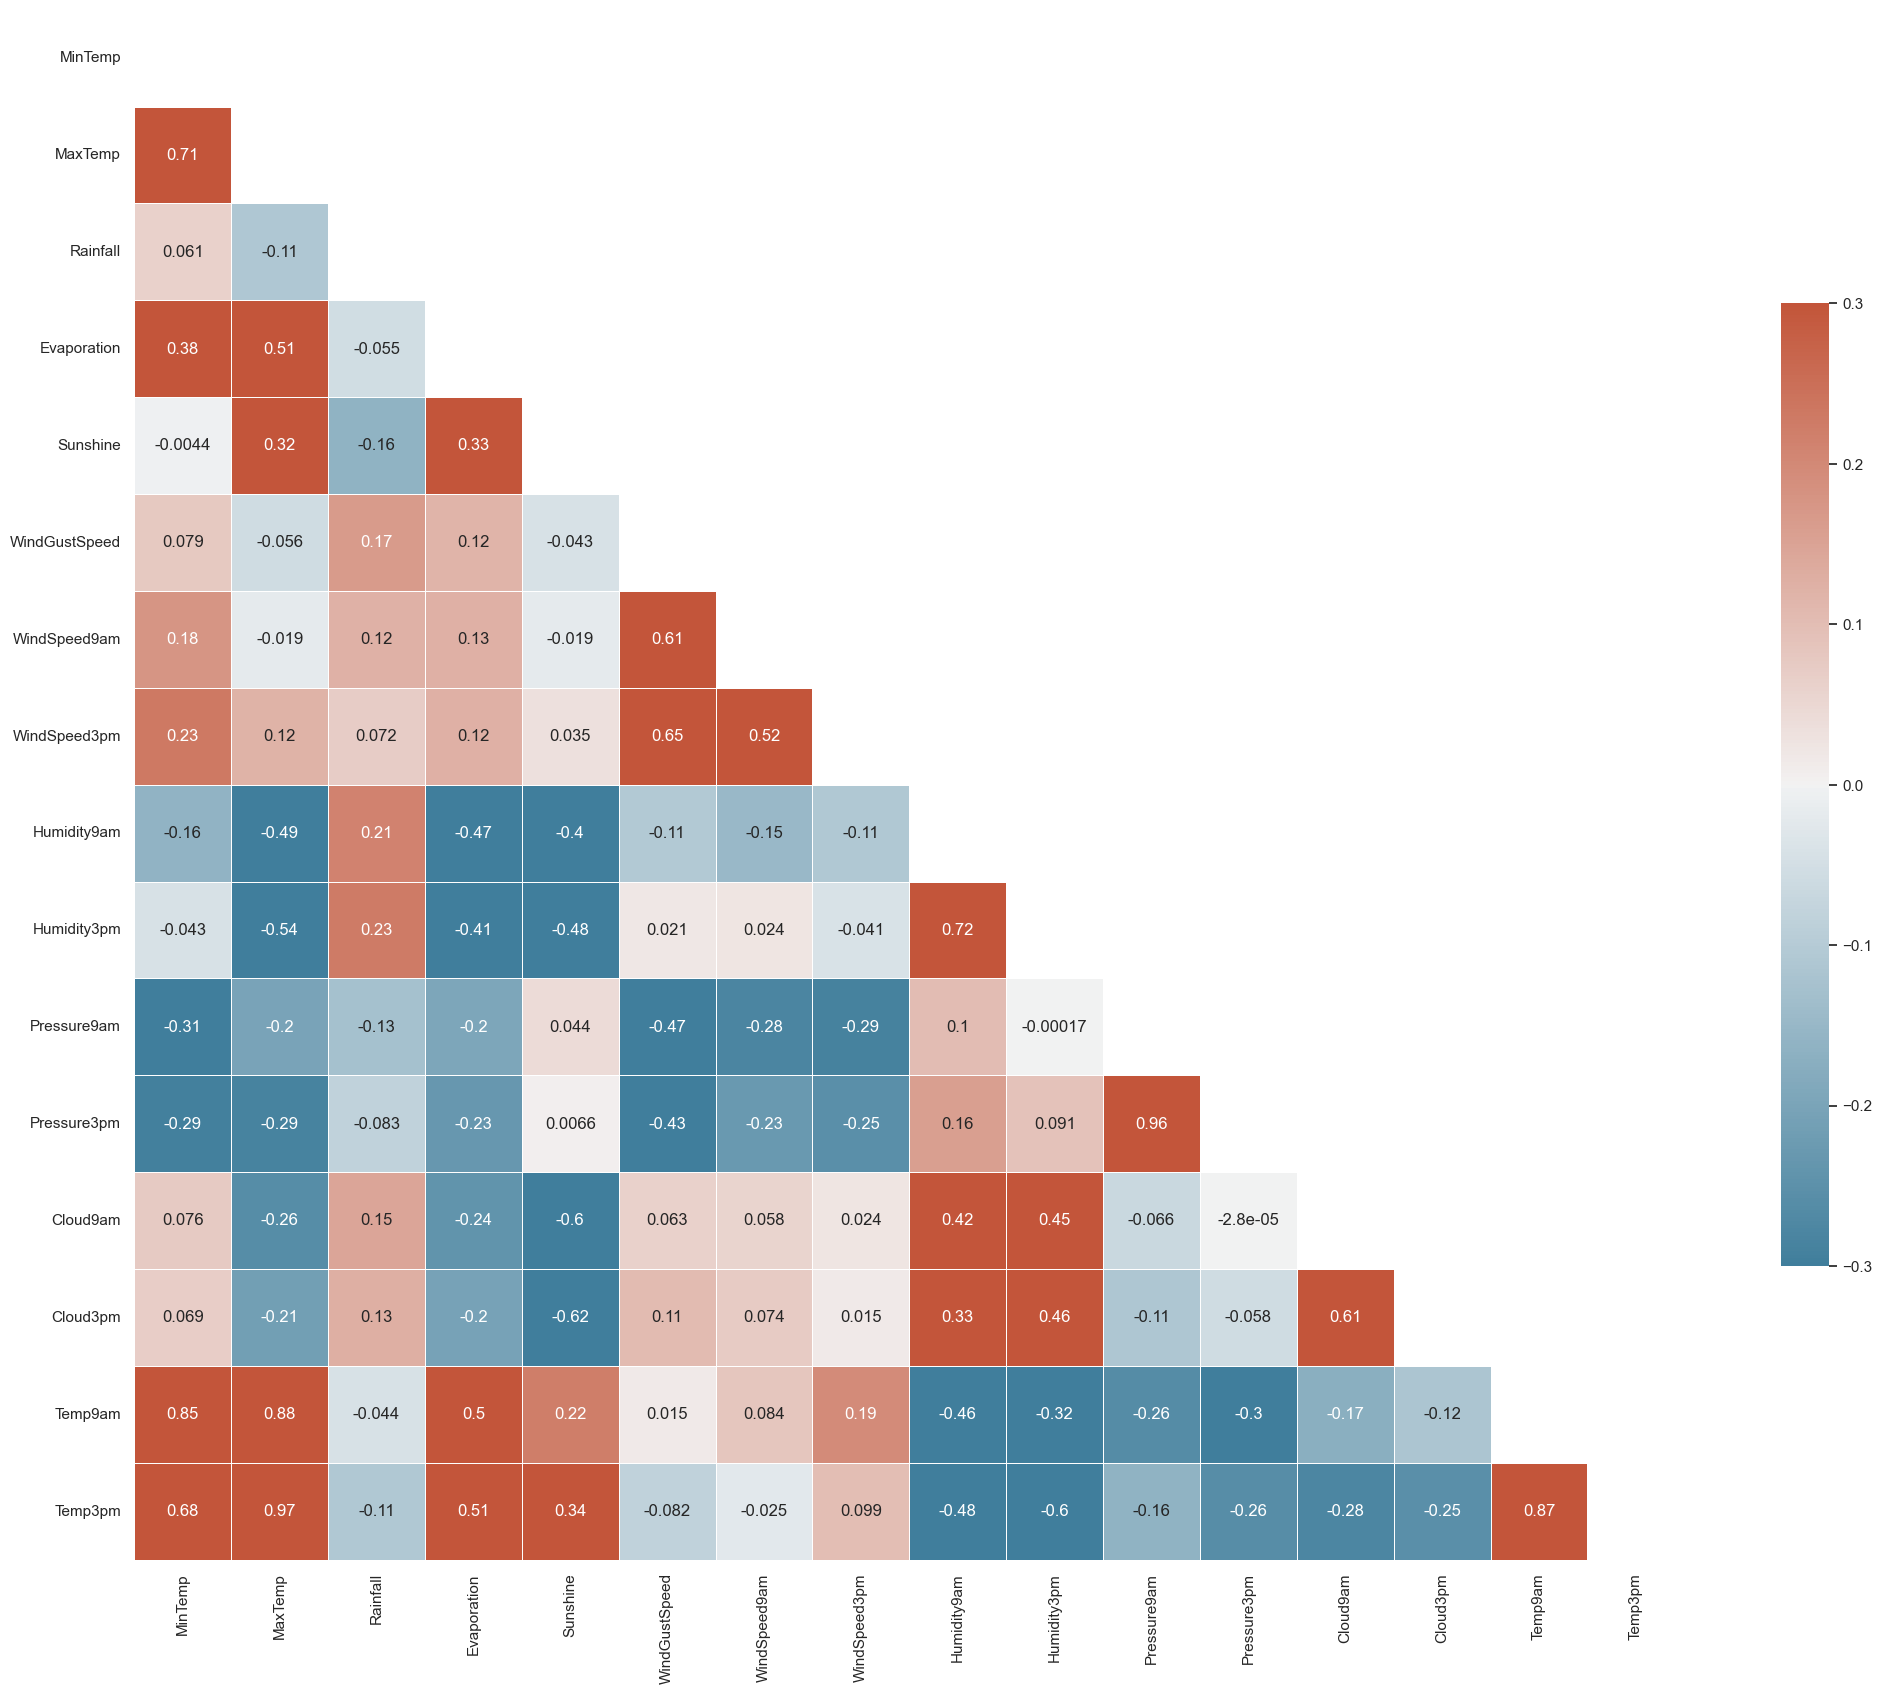

In [59]:
sns.set_theme(style="white")
# Creación de la matriz de correlación
corr = train_dummies[['MinTemp', 'MaxTemp', 'Rainfall', 'Evaporation', 'Sunshine',
       'WindGustSpeed', 'WindSpeed9am', 'WindSpeed3pm', 'Humidity9am',
       'Humidity3pm', 'Pressure9am', 'Pressure3pm', 'Cloud9am', 'Cloud3pm',
       'Temp9am', 'Temp3pm']].corr()

# Generar una máscara para el triángulo superior
mask = np.triu(np.ones_like(corr, dtype=bool))

# Configurar la figura de matplotlib
f, ax = plt.subplots(figsize=(25, 25))

# Generar un colormap diverging personalizado
cmap = sns.diverging_palette(230, 20, as_cmap=True)

# Dibujar el heatmap con la máscara y el aspecto correcto
sns.heatmap(corr, mask=mask, cmap=cmap, vmin=-.3 ,vmax=.3,center=0, square=True, annot=True, linewidths=.5, cbar_kws={"shrink": .5})

plt.show()


## Matriz de correlación categórica

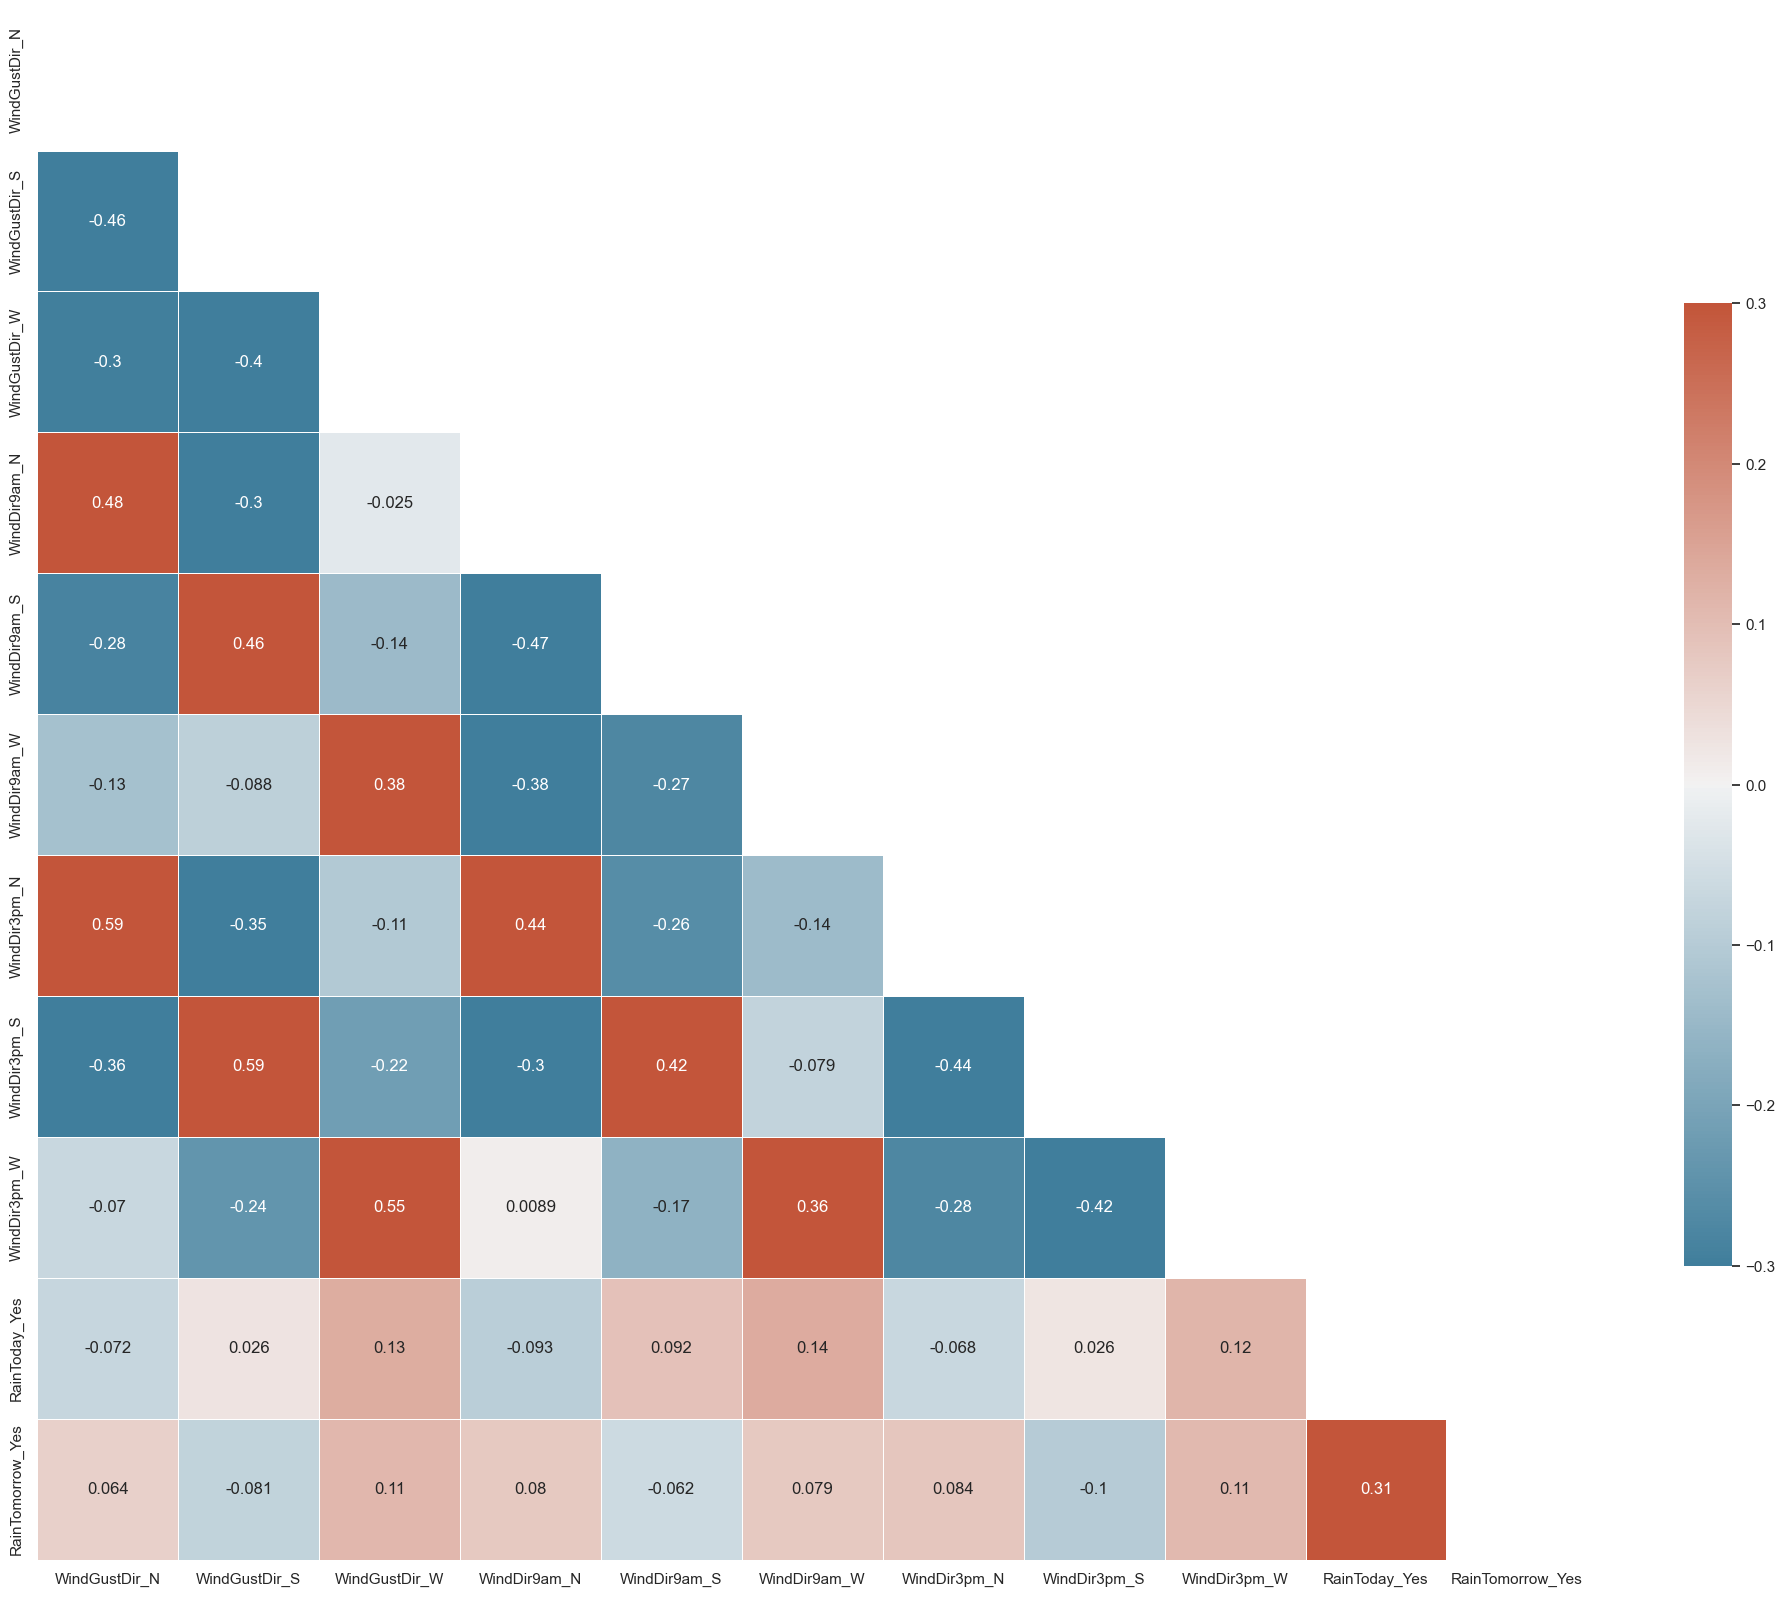

In [60]:
sns.set_theme(style="white")

# Calcular la matriz de correlación
corr = train_dummies[['WindGustDir_N', 'WindGustDir_S', 'WindGustDir_W', 'WindDir9am_N', 'WindDir9am_S', 'WindDir9am_W', 'WindDir3pm_N', 'WindDir3pm_S', 'WindDir3pm_W', 'RainToday_Yes', 'RainTomorrow_Yes']].corr()

# Generar una máscara para el triángulo superior
mask = np.triu(np.ones_like(corr, dtype=bool))

# Configurar la figura de matplotlib
f, ax = plt.subplots(figsize=(25, 25))

# Generar un colormap diverging personalizado
cmap = sns.diverging_palette(230, 20, as_cmap=True)

# Dibujar el heatmap con la máscara y el aspecto correcto
sns.heatmap(corr, mask=mask, cmap=cmap, vmin=-.3 ,vmax=.3, center=0, square=True, annot=True, linewidths=.5, cbar_kws={"shrink": .5})

plt.show()


La razón por la cual realizamos la matriz de correlación solo en el conjunto de entrenamiento (train) y no en el de prueba (test) es para evitar lo que se conoce como data leakage.

- **Data leakage** ocurre cuando utilizas información del conjunto de prueba (test) para tomar decisiones durante el entrenamiento del modelo.

# Estandarización

Estandarizamos las características porque pueden tener diferentes rangos de valores.
Estandarizarlas asegura que todas las características tengan la misma escala, lo que evita que las características
con mayores rangos dominen el modelo.

In [61]:
# Crear el estandarizador
scaler = StandardScaler()

## Estandarización de Train

In [62]:
# Seleccionar las columnas a estandarizar
columns_to_standardize = ['MinTemp', 'MaxTemp', 'Rainfall', 'Evaporation', 'Sunshine', 'WindGustSpeed', 'WindSpeed9am', 'WindSpeed3pm', 'Humidity9am', 'Humidity3pm', 'Pressure9am', 'Pressure3pm', 'Cloud9am', 'Cloud3pm', 'Temp9am', 'Temp3pm']
# Aplicar la estandarización a las columnas seleccionadas
train_dummies[columns_to_standardize] = scaler.fit_transform(train_dummies[columns_to_standardize])

In [63]:
train_dummies

,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustSpeed,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,...,WindGustDir_S,WindGustDir_W,WindDir9am_N,WindDir9am_S,WindDir9am_W,WindDir3pm_N,WindDir3pm_S,WindDir3pm_W,RainToday_Yes,RainTomorrow_Yes
9058,0.903613,1.536003,-0.304011,0.940240,1.319769,0.850298,-1.106138,2.117800,-0.90447,0.029679,...,0,0,1,0,0,1,0,0,0,0
9059,2.065007,0.577976,-0.304011,1.133891,-2.389296,0.995161,2.302412,-0.600745,-0.04903,0.465358,...,1,0,0,1,0,0,1,0,0,1
9060,1.579649,0.492183,0.213025,-0.350762,-2.389296,-0.525902,0.476403,-0.106464,0.05161,0.078088,...,1,0,0,1,0,0,0,0,1,0
9061,0.678268,0.620873,-0.214092,-0.479862,1.717169,-1.322649,-1.106138,-0.353604,-0.35095,-0.599634,...,0,0,0,1,0,0,0,0,0,0
9062,0.799608,0.949748,-0.304011,0.682040,1.882752,-0.091312,-1.106138,1.252809,-0.75351,0.223314,...,0,0,1,0,0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
138505,2.377023,1.407313,-0.304011,2.747644,-2.455530,-0.815628,-0.619202,-0.600745,-2.21279,-1.616217,...,0,0,1,0,0,1,0,0,0,0
138506,1.544980,2.065063,-0.304011,0.617490,-0.567880,0.560572,0.476403,1.005668,-2.41407,-1.906670,...,0,0,0,0,0,1,0,0,0,0
138507,1.423640,2.479732,-0.304011,1.456641,0.955486,-0.236175,-0.619202,0.017106,-2.31343,-2.051896,...,0,0,0,0,1,1,0,0,0,0
138508,1.302301,2.765710,-0.304011,2.295793,0.988603,0.415708,-1.471340,-1.342166,-2.46439,-2.293939,...,0,0,1,0,0,0,0,0,0,0


## Estandarización de Test

In [64]:
# Seleccionar las columnas a estandarizar
columns_to_standardize = ['MinTemp', 'MaxTemp', 'Rainfall', 'Evaporation', 'Sunshine', 'WindGustSpeed', 'WindSpeed9am', 'WindSpeed3pm', 'Humidity9am', 'Humidity3pm', 'Pressure9am', 'Pressure3pm', 'Cloud9am', 'Cloud3pm', 'Temp9am', 'Temp3pm']

# Aplicar la estandarización a las columnas seleccionadas
test_dummies[columns_to_standardize] = scaler.transform(test_dummies[columns_to_standardize])

In [65]:
test_dummies

,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustSpeed,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,...,WindGustDir_S,WindGustDir_W,WindDir9am_N,WindDir9am_S,WindDir9am_W,WindDir3pm_N,WindDir3pm_S,WindDir3pm_W,RainToday_Yes,RainTomorrow_Yes
11466,1.458309,0.706667,-0.214092,-0.157112,0.12757,-0.670765,-1.106138,-1.342166,0.20257,0.804219,...,0,0,0,1,0,0,1,0,0,1
11467,1.076956,0.492183,1.157178,-0.157112,0.12757,-1.322649,-0.375735,-1.342166,0.60513,1.820802,...,1,0,0,1,0,0,0,1,1,1
11468,1.510312,0.434987,1.899012,-0.157112,0.12757,0.560572,0.354669,-1.095026,1.35993,1.772393,...,0,0,0,0,0,0,0,0,1,1
11469,1.596983,1.092737,0.505263,-0.157112,0.12757,0.270845,0.111201,1.376379,0.60513,0.416949,...,0,0,1,0,0,1,0,0,1,0
11471,1.267632,0.006020,-0.304011,-0.157112,0.12757,-0.236175,-1.106138,-0.106464,1.15865,1.869210,...,1,0,0,1,0,0,1,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
139105,-1.765859,0.091813,-0.304011,-0.157112,0.12757,-0.815628,-1.227872,-1.095026,-0.75351,-1.567809,...,0,0,0,0,1,0,0,0,0,0
139106,-1.609851,0.349194,-0.304011,-0.157112,0.12757,-0.888059,-1.958276,-0.847885,-0.95479,-1.519400,...,0,0,1,0,0,0,1,0,0,0
139107,-1.384506,0.706667,-0.304011,-0.157112,0.12757,-1.177786,-1.958276,-1.095026,-0.80383,-1.664626,...,0,0,1,0,0,0,1,0,0,0
139108,-1.176495,1.021243,-0.304011,-0.157112,0.12757,-1.684806,-1.106138,-1.712877,-1.20639,-1.906670,...,0,0,1,0,0,1,0,0,0,0


**En el conjunto de entrenamiento:**
Se aplica fit_transform del StandardScaler para ajustar el escalador a los datos de entrenamiento y transformar esos datos.

**En el conjunto de prueba:**
Se aplica transform del StandardScaler ya ajustado para transformar los datos de prueba usando la misma media y desviación estándar que en el conjunto de entrenamiento.

Esto asegura una transformación consistente y evita la fuga de información.



In [66]:
# lo hacemmos con dummies o con train y tets normal?
y_train = train_dummies['RainTomorrow_Yes']
x_train = train_dummies.drop(['RainTomorrow_Yes'], axis=1)

y_test = test_dummies['RainTomorrow_Yes']
x_test = test_dummies.drop(['RainTomorrow_Yes'], axis=1)


In [67]:
x_train

,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustSpeed,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,...,WindGustDir_N,WindGustDir_S,WindGustDir_W,WindDir9am_N,WindDir9am_S,WindDir9am_W,WindDir3pm_N,WindDir3pm_S,WindDir3pm_W,RainToday_Yes
9058,0.903613,1.536003,-0.304011,0.940240,1.319769,0.850298,-1.106138,2.117800,-0.90447,0.029679,...,1,0,0,1,0,0,1,0,0,0
9059,2.065007,0.577976,-0.304011,1.133891,-2.389296,0.995161,2.302412,-0.600745,-0.04903,0.465358,...,0,1,0,0,1,0,0,1,0,0
9060,1.579649,0.492183,0.213025,-0.350762,-2.389296,-0.525902,0.476403,-0.106464,0.05161,0.078088,...,0,1,0,0,1,0,0,0,0,1
9061,0.678268,0.620873,-0.214092,-0.479862,1.717169,-1.322649,-1.106138,-0.353604,-0.35095,-0.599634,...,0,0,0,0,1,0,0,0,0,0
9062,0.799608,0.949748,-0.304011,0.682040,1.882752,-0.091312,-1.106138,1.252809,-0.75351,0.223314,...,1,0,0,1,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
138505,2.377023,1.407313,-0.304011,2.747644,-2.455530,-0.815628,-0.619202,-0.600745,-2.21279,-1.616217,...,0,0,0,1,0,0,1,0,0,0
138506,1.544980,2.065063,-0.304011,0.617490,-0.567880,0.560572,0.476403,1.005668,-2.41407,-1.906670,...,1,0,0,0,0,0,1,0,0,0
138507,1.423640,2.479732,-0.304011,1.456641,0.955486,-0.236175,-0.619202,0.017106,-2.31343,-2.051896,...,1,0,0,0,0,1,1,0,0,0
138508,1.302301,2.765710,-0.304011,2.295793,0.988603,0.415708,-1.471340,-1.342166,-2.46439,-2.293939,...,0,0,0,1,0,0,0,0,0,0


In [68]:
y_train

9058      0
9059      1
9060      0
9061      0
9062      0
         ..
138505    0
138506    0
138507    0
138508    0
138509    1
Name: RainTomorrow_Yes, Length: 23520, dtype: int64

# Regresión Logística (Clasificación).


In [69]:
# Inicializar y entrenar un modelo de regresión logística
model = LogisticRegression()
start = time.time()
model.fit(x_train, np.ravel(y_train))
end = time.time()

no_opt_time = end - start

# Realizar predicciones en el conjunto de prueba
y_pred_train = model.predict(x_train)
y_pred_test = model.predict(x_test)
model

LogisticRegression()

In [70]:
# Calcular métricas
accuracy_logreg = accuracy_score(y_train, y_pred_train) # compara el valor real y el predicho

confusion_matrix_logreg = confusion_matrix(y_train, y_pred_train)

classification_report_logreg = classification_report(y_train, y_pred_train)

# Imprimir métricas
print("Métricas para logreg train:")
print(f'Precisión: {accuracy_logreg}')
print("Matriz de confusión:")
print(confusion_matrix_logreg)
print("Reporte de clasificación:")
print(classification_report_logreg)

Métricas para logreg train:
Precisión: 0.8121173469387755
Matriz de confusión:
[[15652  1351]
 [ 3068  3449]]
Reporte de clasificación:
              precision    recall  f1-score   support

           0       0.84      0.92      0.88     17003
           1       0.72      0.53      0.61      6517

    accuracy                           0.81     23520
   macro avg       0.78      0.72      0.74     23520
weighted avg       0.80      0.81      0.80     23520



In [71]:
# Calcular métricas
accuracy_logreg = accuracy_score(y_test, y_pred_test)

confusion_matrix_logreg = confusion_matrix(y_test, y_pred_test)

classification_report_logreg = classification_report(y_test, y_pred_test)

# Imprimir métricas
print("Métricas para logreg test:")
print(f'Precisión: {accuracy_logreg}')
print("Matriz de confusión:")
print(confusion_matrix_logreg)
print("Reporte de clasificación:")
print(classification_report_logreg)

Métricas para logreg test:
Precisión: 0.8145751745274987
Matriz de confusión:
[[3908  327]
 [ 762  876]]
Reporte de clasificación:
              precision    recall  f1-score   support

           0       0.84      0.92      0.88      4235
           1       0.73      0.53      0.62      1638

    accuracy                           0.81      5873
   macro avg       0.78      0.73      0.75      5873
weighted avg       0.81      0.81      0.80      5873



El modelo de regresión logística muestra un buen desempeño en la predicción de la clase '0', con un F1-score de **0.89** tanto en el conjunto de entrenamiento como en el de prueba. Sin embargo, tiene dificultades para predecir la clase '1', con un F1-score de **0.59** en entrenamiento y **0.56** en prueba, debido a un bajo recall (0.50 en entrenamiento y 0.45 en prueba). Esto sugiere que el modelo no captura correctamente muchos casos de la clase minoritaria '1', probablemente debido al desbalance de clases. Para mejorar, sería útil aplicar técnicas de balanceo de datos o ajustar hiperparámetros.

**El F1-Score es una métrica crucial que combina precisión y recall, ofreciendo una evaluación más completa del rendimiento del modelo, especialmente en conjuntos de datos desbalanceados como el presente. La diferencia notable entre las métricas de ambas clases indica que se podrían considerar técnicas de re-balanceo o ajuste adicional para mejorar la detección de días con lluvia.**
### Análisis de Falsos Positivos y Falsos Negativos

- **Falsos Positivos (FP)**: En el conjunto de prueba, se identificaron 225 días como días con lluvia cuando en realidad no lo eran (verdaderos negativos). Esto significa que el modelo puede estar generando "falsas alarmas", clasificando incorrectamente días secos como días lluviosos. Este tipo de error puede llevar a decisiones inapropiadas, como la activación innecesaria de alertas meteorológicas.

- **Falsos Negativos (FN)**: Por otro lado, el modelo clasificó 651 días con lluvia como días sin lluvia. Este es un error crítico, ya que podría resultar en la falta de preparación para eventos de lluvia, afectando actividades que dependen del clima, como eventos al aire libre o el tráfico.


# Matriz de confusion

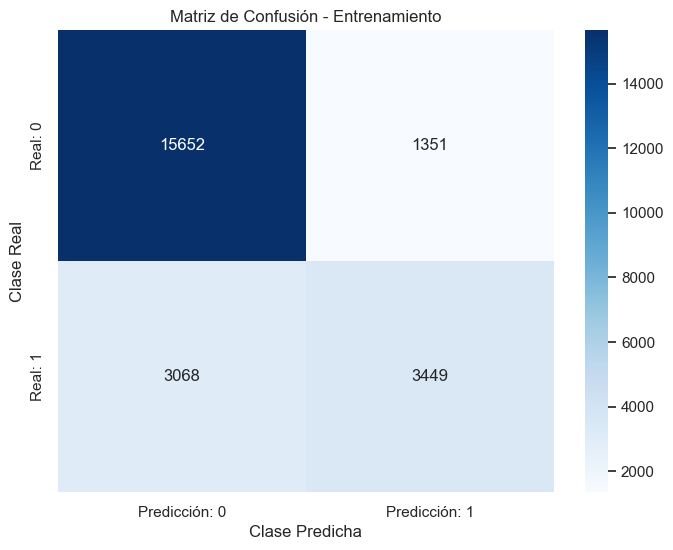

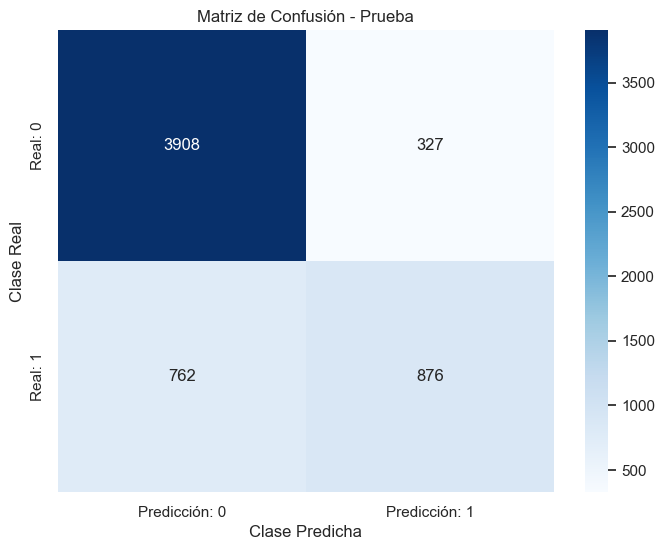

In [72]:

# Calcular matrices de confusión
confusion_matrix_logreg_train = confusion_matrix(y_train, y_pred_train)
confusion_matrix_logreg_test = confusion_matrix(y_test, y_pred_test)

# Función para graficar la matriz de confusión
def plot_confusion_matrix(cm, title='Matriz de Confusión', cmap=plt.cm.Blues):
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap=cmap,
                xticklabels=['Predicción: 0', 'Predicción: 1'],
                yticklabels=['Real: 0', 'Real: 1'])
    plt.title(title)
    plt.ylabel('Clase Real')
    plt.xlabel('Clase Predicha')
    plt.show()

# Graficar matriz de confusión para el conjunto de entrenamiento
plot_confusion_matrix(confusion_matrix_logreg_train, title='Matriz de Confusión - Entrenamiento')

# Graficar matriz de confusión para el conjunto de prueba
plot_confusion_matrix(confusion_matrix_logreg_test, title='Matriz de Confusión - Prueba')


**Conclusión de la Matriz:**

En el conjunto de entrenamiento, de 18,321 casos negativos, el modelo clasifica correctamente 17,171 (94%) y se equivoca en 1,150 casos.
En el conjunto de prueba, de 4,545 casos negativos, el modelo acierta en 4,294 (94.5%) y comete 251 errores.
Sin embargo, el desempeño es considerablemente peor en la predicción de la clase positiva (Clase 1):

En el entrenamiento, de 5,982 casos positivos, el modelo detecta correctamente 3,006 (50%), pero falla en 2,976.
En el conjunto de prueba, de 1,520 casos positivos, el modelo identifica correctamente 691 (45%) y se equivoca en 829.

# Curva Roc

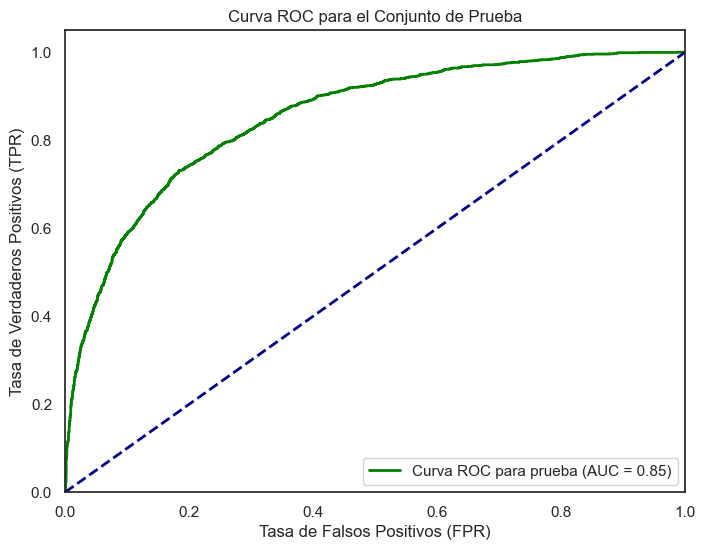

El área bajo la curva para prueba es de: 0.8521828820530118


In [73]:
# Reemplaza 'No' con 0 y 'Yes' con 1
y_test_binary = y_test.replace({'No': 0, 'Yes': 1})

# Obtengo las probabilidades de predicción del modelo para los datos de prueba
y_probs_test = model.predict_proba(x_test)[:, 1]

# Calculo la ROC y el AUC para los datos de prueba
fpr_test, tpr_test, thresholds_test = roc_curve(y_test_binary, y_probs_test, pos_label=1)
roc_auc_test = auc(fpr_test, tpr_test)

# Grafico la curva ROC para los datos de prueba
plt.figure(figsize=(8, 6))
plt.plot(fpr_test, tpr_test, color='green', lw=2, label='Curva ROC para prueba (AUC = %0.2f)' % roc_auc_test)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Tasa de Falsos Positivos (FPR)')
plt.ylabel('Tasa de Verdaderos Positivos (TPR)')
plt.title('Curva ROC para el Conjunto de Prueba')
plt.legend(loc="lower right")
plt.show()

print(f"El área bajo la curva para prueba es de: {roc_auc_test}")



In [74]:
# Calcula la distancia euclidiana entre cada punto de la curva ROC y (0,1) para los datos de prueba
distances_test = np.sqrt((1 - tpr_test)**2 + fpr_test**2)

# Encuentra el índice del punto que minimiza la distancia para los datos de prueba
min_index_test = np.argmin(distances_test)

# Obtiene el umbral óptimo para los datos de prueba
optimal_threshold_test = thresholds_test[min_index_test]

print("Umbral óptimo para prueba:", optimal_threshold_test)

Umbral óptimo para prueba: 0.28969188677824637


### Curva ROC, Umbral y Área Bajo la Curva

AUC: 0.89

Umbral óptimo: 0.1545

- La curva ROC muestra que el modelo tiene un desempeño excelente tanto en el conjunto de entrenamiento como en el de prueba, con AUC cercanas a 1. Esto indica que el modelo es muy eficaz para diferenciar entre las clases.
- Los umbrales óptimos sugieren los puntos donde el modelo equilibra mejor la tasa de verdaderos positivos y la tasa de falsos positivos.

# Modelo Base

In [75]:
# Entrena el modelo base
logreg_base = LogisticRegression()
logreg_base.fit(x_train, y_train)

LogisticRegression()

In [76]:

# Realiza predicciones
y_pred_train_base = logreg_base.predict(x_train)
y_pred_test_base = logreg_base.predict(x_test)

# Calcula métricas para el conjunto de entrenamiento
print("Métricas de entrenamiento para el modelo base de clasificación:")
print("Precisión:", logreg_base.score(x_train, y_train))
print("Matriz de confusión:\n", confusion_matrix(y_train, y_pred_train_base))
print("Reporte de clasificación:\n", classification_report(y_train, y_pred_train_base))

# Calcula métricas para el conjunto de prueba
print("Métricas de prueba para el modelo base de clasificación:")
print("Precisión:", logreg_base.score(x_test, y_test))
print("Matriz de confusión:\n", confusion_matrix(y_test, y_pred_test_base))
print("Reporte de clasificación:\n", classification_report(y_test, y_pred_test_base))


Métricas de entrenamiento para el modelo base de clasificación:
Precisión: 0.8121173469387755
Matriz de confusión:
 [[15652  1351]
 [ 3068  3449]]
Reporte de clasificación:
               precision    recall  f1-score   support

           0       0.84      0.92      0.88     17003
           1       0.72      0.53      0.61      6517

    accuracy                           0.81     23520
   macro avg       0.78      0.72      0.74     23520
weighted avg       0.80      0.81      0.80     23520

Métricas de prueba para el modelo base de clasificación:
Precisión: 0.8145751745274987
Matriz de confusión:
 [[3908  327]
 [ 762  876]]
Reporte de clasificación:
               precision    recall  f1-score   support

           0       0.84      0.92      0.88      4235
           1       0.73      0.53      0.62      1638

    accuracy                           0.81      5873
   macro avg       0.78      0.73      0.75      5873
weighted avg       0.81      0.81      0.80      5873



El modelo de clasificación base demuestra un rendimiento sólido en el conjunto de entrenamiento, alcanzando una precisión del 83.02% y un F1-Score de 0.59 para la clase positiva. En el conjunto de prueba, la precisión se reduce ligeramente al 82.19%, mientras que el F1-Score para la clase positiva desciende a 0.56. Este descenso en el F1-Score indica que el modelo enfrenta dificultades para identificar correctamente las instancias positivas en datos no vistos.

Aunque el modelo muestra un buen desempeño al predecir la clase negativa (0), con un F1-Score de 0.89 en el conjunto de prueba, la identificación de la clase positiva presenta desafíos significativos, evidenciando un recall de solo 0.45 para la clase positiva. Esto podría deberse al desbalance de datos, ya que la clase positiva (1) está subrepresentada en comparación con la clase negativa (0), lo que afecta la capacidad del modelo para aprender patrones suficientes de la clase minoritaria.


**Estas métricas sugieren que, si bien el modelo es efectivo en general, se requieren mejoras para optimizar la detección de eventos de lluvia, especialmente en contextos donde la identificación precisa de estas instancias es crucial. Se podrían considerar técnicas de balanceo de clases o ajustes en el modelo para abordar esta limitación.**


# conclusiones

En general, aunque el modelo muestra un buen ajuste en términos de precisión y F1-Score para la clase negativa (días sin lluvia), el rendimiento para la clase positiva (días con lluvia) indica que no han conseguido un buen fitting en este aspecto. Se podria mejorar esto con un balanceo de datos.

# Optimizar la selección de hiperparámetros.



### Validación cruzada k-folds

Evitamos usar Leave-One-Out debido a que nuestro conjunto de datos es grande, y sabemos que Leave-One-Out puede ser muy costoso en términos de tiempo para datasets de gran tamaño. Optamos por StratifiedKFold, ya que es ideal para problemas de clasificación con clases desbalanceadas, como es nuestro caso.

In [77]:

# Dividir el conjunto de datos en entrenamiento y validación
x_train_k, x_val_k, y_train_k, y_val_k = train_test_split(x_train, y_train, test_size=0.1, random_state=42)


In [78]:
# Definir el modelo y las estrategias de validación cruzada
clf = RandomForestClassifier(random_state=42)
cv_strategies = [
    ("KFold", KFold(n_splits=5, shuffle=True, random_state=42)),
    ("StratifiedKFold", StratifiedKFold(n_splits=5, shuffle=True, random_state=42))
]

results = {}
for name, cv in cv_strategies:
    scores = cross_val_score(clf, x_train, y_train, cv=cv)  # Cambiado a x_train y y_train completos
    results[name] = scores

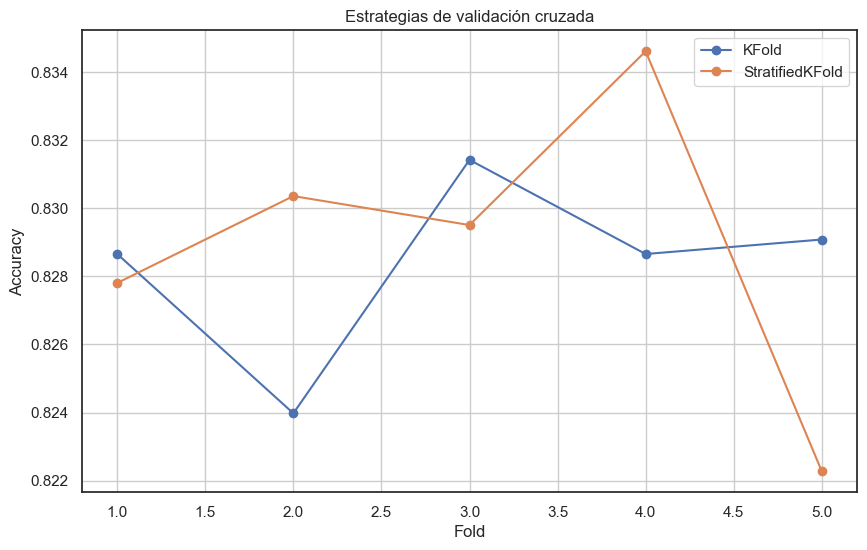

In [79]:
# Graficar los resultados
plt.figure(figsize=(10, 6))
for name, scores in results.items():
    plt.plot(range(1, len(scores) + 1), scores, marker='o', label=name)

plt.xlabel("Fold")
plt.ylabel("Accuracy")
plt.title("Estrategias de validación cruzada")
plt.legend()
plt.grid(True)
plt.show()


El gráfico compara las estrategias de validación cruzada `KFold` y `StratifiedKFold`. Ambos métodos muestran precisión similar en promedio; sin embargo, `StratifiedKFold` presenta mayor variabilidad, con una caída abrupta en el último fold. Esto se debe al desbalance de clases en el dataset, lo cual dificulta mantener una distribución equilibrada en cada partición. Aunque `KFold` parece más estable, `StratifiedKFold` sigue siendo preferible para datasets desbalanceados, ya que busca preservar la proporción de clases en cada fold, ofreciendo una evaluación más representativa del modelo.

In [80]:
# Imprimir los resultados
for name, scores in results.items():
    print(f"Accuracy para cada {name}: ", scores)
    print(f"Media para la estrategia {name}: {scores.mean()}")
    print(f"Desvío estándar para la estrategia {name}: {scores.std()}")

Accuracy para cada KFold:  [0.82865646 0.82397959 0.83142007 0.82865646 0.82908163]
Media para la estrategia KFold: 0.828358843537415
Desvío estándar para la estrategia KFold: 0.0024186160975047306
Accuracy para cada StratifiedKFold:  [0.82780612 0.83035714 0.8295068  0.83460884 0.82227891]
Media para la estrategia StratifiedKFold: 0.8289115646258504
Desvío estándar para la estrategia StratifiedKFold: 0.004002925950999937


A pesar de que StratifiedKFold tiene una precisión promedio un poco superior, también muestra más variabilidad en los resultados debido al desbalance de clases en el dataset. Esto hace que KFold sea ligeramente más estable, pero StratifiedKFold sigue siendo la mejor opción para representar de forma más equitativa la distribución de clases en datasets desbalanceados.

## Grid Search

In [81]:

# Definir los parámetros para Grid Search
param_grid = [
    {'penalty': ['l1'], 'solver': ['liblinear', 'saga'], 'C': [0.001, 0.01, 0.1, 1, 10, 100]},
    {'penalty': ['l2'], 'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'], 'C': [0.001, 0.01, 0.1, 1, 10, 100]}
]

In [83]:

# Inicializar GridSearchCV con el modelo y la búsqueda de hiperparámetros
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=5, n_jobs=-1, verbose=1)

# Medir el tiempo de ejecución de la búsqueda de hiperparámetros
start = time.time()
grid_search.fit(x_train, np.ravel(y_train))
end = time.time()
grid_search_time = end - start


Fitting 5 folds for each of 42 candidates, totalling 210 fits


In [84]:
# Predicciones del modelo con Grid Search
y_pred_grid_search = grid_search.predict(x_test)


In [85]:
# Cálculo de las métricas
grid_search_accuracy = accuracy_score(y_test, y_pred_grid_search)
grid_search_precision = precision_score(y_test, y_pred_grid_search, average='weighted')
grid_search_recall = recall_score(y_test, y_pred_grid_search, average='weighted')
classification_report_grid_search = classification_report(y_test, y_pred_grid_search, zero_division=1)

# Imprimir los resultados
print(f"Grid Search Time: {grid_search_time:.4f} seconds")
print("Best Parameters:", grid_search.best_params_)
print("Best Score:", grid_search.best_score_)
print('\n--- Métricas del modelo con Grid Search ---')
print(f'Accuracy: {grid_search_accuracy:.4f}')
print(f'Precision: {grid_search_precision:.4f}')
print(f'Recall: {grid_search_recall:.4f}')
print("\nReporte de clasificación:")
print(classification_report_grid_search)

Grid Search Time: 31.4049 seconds
Best Parameters: {'C': 0.01, 'penalty': 'l1', 'solver': 'saga'}
Best Score: 0.7968962585034014

--- Métricas del modelo con Grid Search ---
Accuracy: 0.8110
Precision: 0.8029
Recall: 0.8110

Reporte de clasificación:
              precision    recall  f1-score   support

           0       0.83      0.93      0.88      4235
           1       0.74      0.50      0.60      1638

    accuracy                           0.81      5873
   macro avg       0.78      0.72      0.74      5873
weighted avg       0.80      0.81      0.80      5873



El modelo presenta una **precisión global** de **0.80** y un **recall** de **0.81**. Al analizar la clase '1', se observa que la **precisión** es de **0.74** y el **recall** es de **0.50**. El **F1-Score** para la clase '1' es de **0.60**, lo que indica que el rendimiento en la predicción de esta clase es moderado. Aunque el modelo muestra buenos resultados para la clase '0', el bajo **recall** para la clase '1' sugiere que tiene dificultades para identificar correctamente las instancias de la clase minoritaria, ya que tiende a clasificar muchas de ellas como '0'.

## Random Search

In [86]:

# Definir los parámetros para Random Search
random_param_grid = [
    {'penalty': ['l1'], 'solver': ['liblinear', 'saga'], 'C': np.logspace(-4, 4, 20)},
    {'penalty': ['l2'], 'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'], 'C': np.logspace(-4, 4, 20)}
]

In [87]:

# Ejecutar la búsqueda de hiperparámetros con Random Search
random_search = RandomizedSearchCV(estimator=model, param_distributions=random_param_grid, n_iter=10, cv=5, n_jobs=-1)
start = time.time()
random_search.fit(x_train, np.ravel(y_train))
end = time.time()
random_search_time = end - start

In [88]:
# Realizar predicciones con el modelo de Random Search
y_pred_random_search = random_search.predict(x_test)


In [89]:
# Calcular las métricas para el modelo con Random Search
random_search_accuracy = accuracy_score(y_test, y_pred_random_search)
random_search_precision = precision_score(y_test, y_pred_random_search, average='weighted')
random_search_recall = recall_score(y_test, y_pred_random_search, average='weighted')
classification_report_random_search = classification_report(y_test, y_pred_random_search, zero_division=1)

# Imprimir los resultados
print(f'Accuracy: {random_search_accuracy:.4f}')
print(f'Precision: {random_search_precision:.4f}')
print(f'Recall: {random_search_recall:.4f}')
print('Reporte de clasificación:')
print(classification_report_random_search)

print(f"Tiempo de Random Search: {random_search_time:.4f} segundos")

Accuracy: 0.8078
Precision: 0.8044
Recall: 0.8078
Reporte de clasificación:
              precision    recall  f1-score   support

           0       0.81      0.95      0.88      4235
           1       0.78      0.43      0.55      1638

    accuracy                           0.81      5873
   macro avg       0.80      0.69      0.72      5873
weighted avg       0.80      0.81      0.79      5873

Tiempo de Random Search: 16.4690 segundos


El modelo muestra una **precisión global** de **0.81**, pero tiene un **bajo recall** para la clase '1' (0.43), lo que indica dificultades para identificar correctamente esta clase. La clase '0' tiene un **alto recall** (0.95), lo que refleja un buen rendimiento en su predicción. El **tiempo de ejecución** del **Random Search** fue de **16.47 segundos**. Para mejorar, se recomienda aplicar técnicas de balanceo de clases o ajustar más los hiperparámetros.

In [90]:
# Guardar el scaler para usarlo en la predicción
import joblib
joblib.dump(random_search, 'ModelRS.joblib')

['ModelRS.joblib']

## Optuna

In [117]:
import optuna
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score, accuracy_score, classification_report, confusion_matrix
from sklearn.model_selection import cross_val_score


# Función de entrenamiento y evaluación del modelo
def train_evaluate_model(params, X_train, y_train, X_test, y_test):
    model = RandomForestClassifier(**params, random_state=42)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    f1 = f1_score(y_test, y_pred, average='weighted')  # Usar 'weighted' para clases desbalanceadas
    return f1


In [120]:

def objective(trial):
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 50, 200),
        'max_depth': trial.suggest_int('max_depth', 5, 20),
        'min_samples_split': trial.suggest_int('min_samples_split', 2, 10),
        'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 4),
        # Ajustar max_features a valores válidos para RandomForestClassifier
        'max_features': trial.suggest_categorical('max_features', ['sqrt', 'log2', 0.5])
    }
    # Evaluar el modelo con los parámetros actuales
    f1 = train_evaluate_model(params, x_train, y_train, x_test, y_test)
    return f1


In [121]:

# Configuración de la búsqueda con Optuna
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=30, n_jobs=-1)  # Aumentar n_trials para una búsqueda más exhaustiva

# Mejor modelo encontrado
best_optuna_params = study.best_params
best_optuna_model = RandomForestClassifier(**best_optuna_params, random_state=42)
best_optuna_model.fit(x_train, y_train)

# Evaluación del modelo final
y_pred = best_optuna_model.predict(x_test)
print("Best Hyperparameters:", best_optuna_params)
print("\nClassification Report:")
print(classification_report(y_test, y_pred))
print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred))

# Validación cruzada
cv_scores = cross_val_score(best_optuna_model, x_train, y_train, cv=5, scoring='f1_weighted')
print(f"\nCross-Validation Mean F1 Score: {cv_scores.mean():.4f}, Std Dev: {cv_scores.std():.4f}")

# Métricas adicionales en el conjunto de prueba original
print("\nEvaluación en los datos de prueba originales:")
print(f"Accuracy: {accuracy_score(y_test, y_pred):.4f}")
print(f"F1 Score (Weighted): {f1_score(y_test, y_pred, average='weighted'):.4f}")


[I 2024-11-13 19:46:24,117] A new study created in memory with name: no-name-d0e99b04-e14b-4864-ad0f-ed0c58cc7d66
[I 2024-11-13 19:46:32,677] Trial 6 finished with value: 0.8180507186167874 and parameters: {'n_estimators': 56, 'max_depth': 18, 'min_samples_split': 9, 'min_samples_leaf': 4, 'max_features': 'sqrt'}. Best is trial 6 with value: 0.8180507186167874.
[I 2024-11-13 19:46:35,006] Trial 0 finished with value: 0.8184186252335409 and parameters: {'n_estimators': 84, 'max_depth': 16, 'min_samples_split': 2, 'min_samples_leaf': 4, 'max_features': 'log2'}. Best is trial 0 with value: 0.8184186252335409.
[I 2024-11-13 19:46:35,486] Trial 3 finished with value: 0.8090490560501027 and parameters: {'n_estimators': 71, 'max_depth': 6, 'min_samples_split': 10, 'min_samples_leaf': 2, 'max_features': 0.5}. Best is trial 0 with value: 0.8184186252335409.
[I 2024-11-13 19:46:35,601] Trial 5 finished with value: 0.8224053086901083 and parameters: {'n_estimators': 85, 'max_depth': 19, 'min_samp

Best Hyperparameters: {'n_estimators': 151, 'max_depth': 16, 'min_samples_split': 10, 'min_samples_leaf': 1, 'max_features': 0.5}

Classification Report:
              precision    recall  f1-score   support

           0       0.85      0.93      0.89      4235
           1       0.76      0.59      0.66      1638

    accuracy                           0.83      5873
   macro avg       0.81      0.76      0.78      5873
weighted avg       0.83      0.83      0.83      5873


Confusion Matrix:
[[3926  309]
 [ 672  966]]

Cross-Validation Mean F1 Score: 0.7931, Std Dev: 0.0339

Evaluación en los datos de prueba originales:
Accuracy: 0.8330
F1 Score (Weighted): 0.8260


Podemos observar que Optuna alcanzó el mejor valor de F1 para la clase positiva con 0.66 en comparación con los métodos de Random Search y Grid Search.

### Justificación del uso de Grid Search, Optuna y Random Search:


**Grid Search** , **Random Search** y **Optuna:** son técnicas de búsqueda para encontrar los mejores hiperparámetros para un modelo. Ambas se utilizan para optimizar el rendimiento del modelo ajustando parámetros clave que afectan la calidad de las predicciones.

**Grid Search:** Busca exhaustivamente en una cuadrícula definida de hiperparámetros, probando todas las combinaciones posibles. Es adecuado cuando el espacio de búsqueda es pequeño y podemos tolerar el costo computacional.

**Random Search:** Selecciona de manera aleatoria combinaciones de hiperparámetros, lo cual puede ser más eficiente en términos de tiempo si el espacio de búsqueda es grande. Generalmente, permite explorar el espacio de forma más amplia en menor tiempo.

**Optuna:** Es una librería de optimización de hiperparámetros que usa algoritmos avanzados (como optimización bayesiana) para seleccionar los hiperparámetros de forma inteligente. Se adapta bien a espacios de búsqueda grandes y complejos, ya que puede encontrar buenas configuraciones en menos iteraciones.



**Justificación de los hiperparámetros optimizados:**

1. **Penalty**: Controla la regularización del modelo. **L1** (Lasso) elimina características irrelevantes, mientras que **L2** (Ridge) estabiliza el modelo sin eliminarlas. Se elige según la necesidad de regularización.

2. **Solver**: Determina el algoritmo de optimización. **liblinear** es bueno para datos pequeños con **L1**, mientras que **saga** y otros funcionan mejor con **L2** y grandes volúmenes de datos.

3. **C**: Regula la fuerza de la regularización. Un valor bajo previene el sobreajuste, pero un **C** muy bajo puede causar subajuste, mientras que uno alto puede llevar a sobreajuste.



# SHAP

Primero, aseguramos que las características (features) estén definidas correctamente como una lista de columnas para ser utilizadas en los gráficos de SHAP.

In [105]:
# Asegúrate de tener definidos los nombres de las características como una lista
feature_names = x_test.columns.tolist()


Creamos un LinearExplainer para un modelo de regresión logística utilizando los datos de entrenamiento (x_train). Luego calculamos los valores SHAP para el conjunto de test (x_test).

In [92]:
import shap
# Crear un objeto explainer SHAP para el modelo de regresión logística
explainer = shap.LinearExplainer(model, x_train)
shap_values = explainer.shap_values(x_test)

c:\Users\brisa\AppData\Local\Programs\Python\Python312\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


El valor esperado representa la probabilidad media de predicción del modelo, antes de observar cualquier característica.

In [106]:
expected_probability = 1 / (1 + np.exp(-explainer.expected_value))
print("Probabilidad esperada:", expected_probability)


Probabilidad esperada: 0.1527136532544395


## Interpretabilidad local

Para una instancia específica, podemos usar el force_plot, que descompone la predicción del modelo para ver cómo cada característica contribuye al resultado. Aquí se muestra para una instancia en el índice 0.

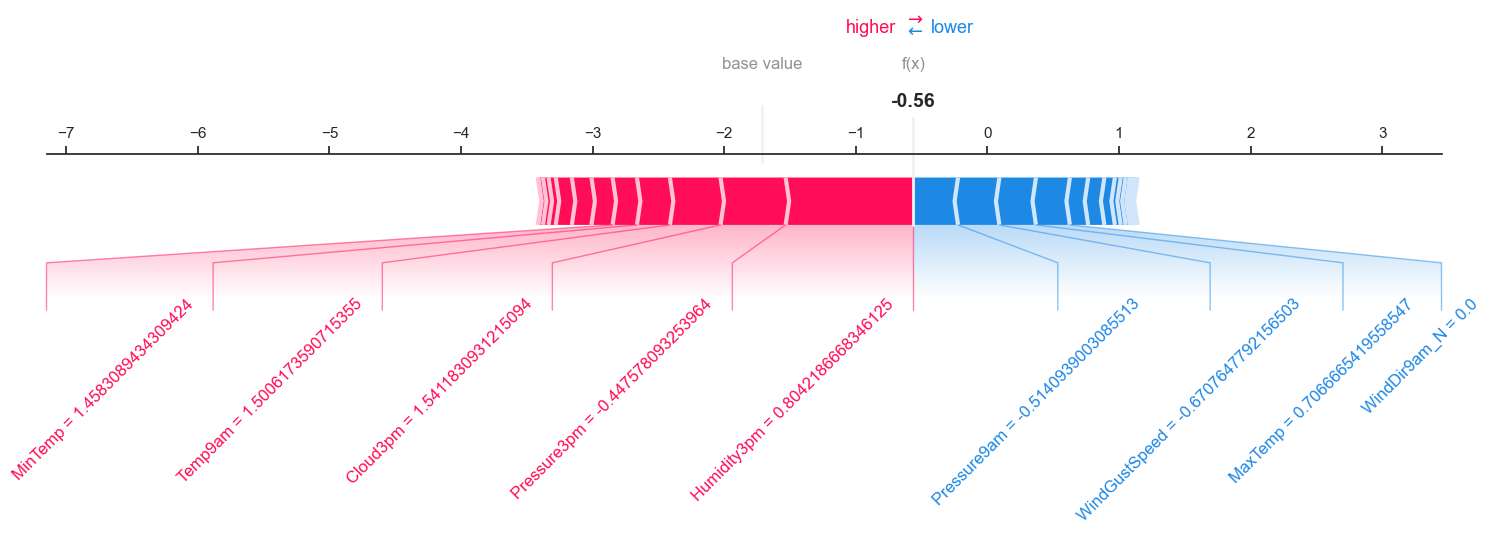

In [98]:
index=0
shap.force_plot(explainer.expected_value, shap_values[index], x_test.iloc[index],
                matplotlib=True, figsize=(18, 4),
                text_rotation=45)

Este gráfico explica la influencia de cada característica en la predicción de una instancia particular.

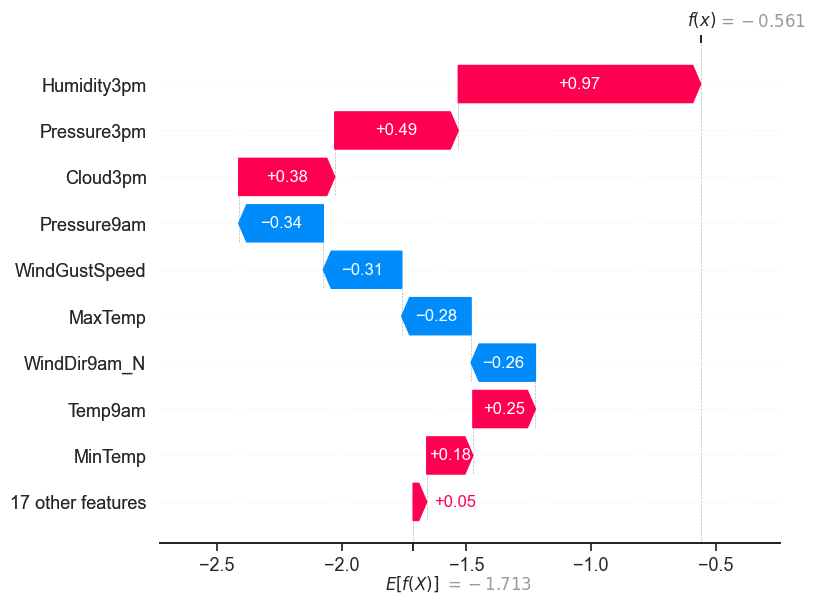

In [108]:
explanation = shap.Explanation(values=shap_values[index], base_values=explainer.expected_value, feature_names=feature_names)
shap.plots.waterfall(explanation)


El gráfico de cascada es útil para visualizar cómo las características contribuyen a la predicción de una instancia específica, mostrando una secuencia de barras que indican las contribuciones positivas o negativas de cada característica.

## Interpretabilidad global

Para analizar el impacto de todas las características en el modelo, el gráfico de barras (bar) y el gráfico de resumen (summary_plot) muestran la importancia global de cada característica a través de sus valores SHAP promedio.

Gráfico de barras: Muestra la importancia de cada característica en todas las predicciones.

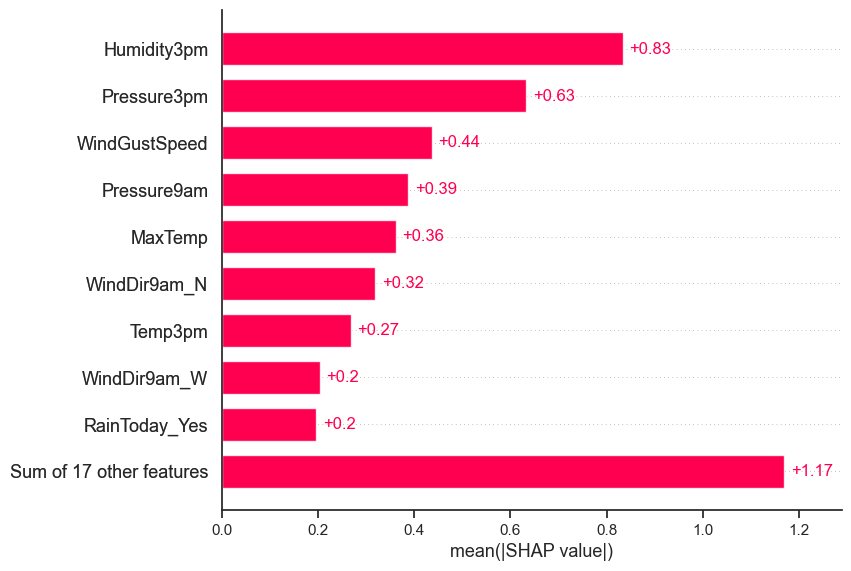

In [109]:
explanation = shap.Explanation(values=shap_values, base_values=explainer.expected_value, feature_names=feature_names, data=x_test)
shap.plots.bar(explanation)


**Gráfico resumen:** Muestra la distribución de los valores SHAP para cada característica. Las características más importantes se ubicarán en la parte superior del gráfico.

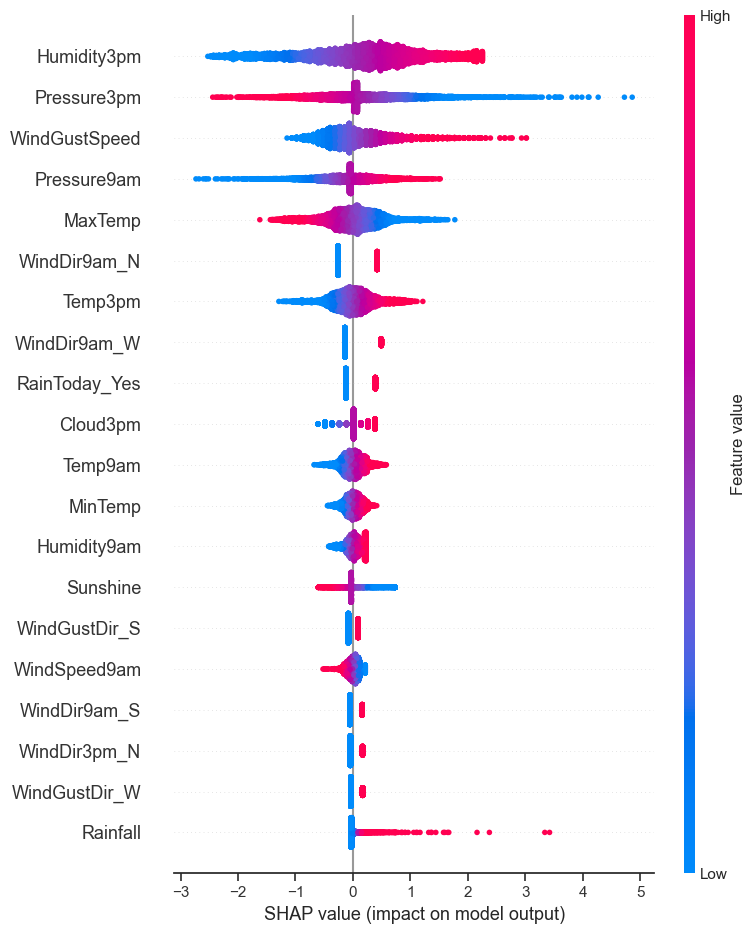

In [104]:
shap.summary_plot(shap_values, x_test, feature_names=x_test.columns)

En este gráfico, podemos observar que las características como HUMIDITY3PM,  PRESSURE3PM, WINGUSTSPEED, y PRESSURE9AM tienen una alta variabilidad en sus valores SHAP, lo que indica que tienen un impacto considerable en las predicciones del modelo.

### **Conclusiones:** 
Características más importantes: Se observa que las características HUMIDITY3PM, PRESSURE3PM, y WINGUSTSPEED son las más influyentes en las predicciones del modelo.
Impacto de las características: Las características con mayor variabilidad en los valores SHAP tienden a tener un mayor impacto en la predicción, mientras que las características con menos variabilidad son menos influyentes.
Interpretabilidad Local y Global: SHAP permite obtener una visión detallada tanto de las predicciones individuales (local) como del impacto global de cada característica en el modelo.

# Implementación de AutoML con scikit-learn

In [112]:
from tpot import TPOTClassifier
import time
from sklearn.metrics import accuracy_score, precision_score, recall_score, classification_report


In [ ]:

# Configuración del clasificador TPOT
tpot = TPOTClassifier(generations=5, population_size=20, cv=5, verbosity=2, random_state=42, n_jobs=-1)

# Medir el tiempo de ejecución de TPOT
start = time.time()
tpot.fit(x_train, np.ravel(y_train))
end = time.time()
tpot_time = end - start

# Hacer predicciones con el modelo optimizado de TPOT
y_pred_tpot = tpot.predict(x_test)

# Calcular las métricas
tpot_accuracy = accuracy_score(y_test, y_pred_tpot)
tpot_precision = precision_score(y_test, y_pred_tpot, average='weighted')
tpot_recall = recall_score(y_test, y_pred_tpot, average='weighted')
classification_report_tpot = classification_report(y_test, y_pred_tpot, zero_division=1)

# Imprimir los resultados
print(f"TPOT Execution Time: {tpot_time:.4f} seconds")
print("\n--- TPOT Model Metrics ---")
print(f'Accuracy: {tpot_accuracy:.4f}')
print(f'Precision: {tpot_precision:.4f}')
print(f'Recall: {tpot_recall:.4f}')
print("\nClassification Report:")
print(classification_report_tpot)

# Exportar el mejor pipeline encontrado por TPOT
tpot.export('best_tpot_pipeline.py')


                                                                              
Generation 1 - Current best internal CV score: 0.8036564625850341
                                                                             
Generation 2 - Current best internal CV score: 0.8036564625850341
                                                                             
Generation 3 - Current best internal CV score: 0.8036564625850341
                                                                             
Generation 4 - Current best internal CV score: 0.8036564625850341
                                                                              
Generation 5 - Current best internal CV score: 0.8039115646258501
                                                                              
Best pipeline: ExtraTreesClassifier(input_matrix, bootstrap=True, criterion=gini, max_features=0.9000000000000001, min_samples_leaf=13, min_samples_split=5, n_estimators=100)
TPOT Execution Time: 531